In [14]:
# Load tensors.pkl and assign variables with their original names
import os
import pickle
import numpy as np

FNAME = "tensors.pkl"

# Whitelist of expected keys (prevents accidental injection of unwanted names)
EXPECTED_KEYS = [
    "tensorNEP_rewarded100pp",
    "tensorNEP_rewarded500pp",
    "tensorNEP_rewarded100hp",
    "tensorNEP_rewarded500hp",
    "tensorNEP_all100pp",
    "tensorNEP_all500pp",
    "tensorNEP_all100hp",
    "tensorNEP_all500hp",
    "tensorTE_filt_100pp",
    "tensorTE_filt_500pp",
    "tensorTE_filt_100hp",
    "tensorTE_filt_500hp",
    "tensorTE_filt_100pp_rewarded",
    "tensorTE_filt_100hp_rewarded",
    "reward_arms",
    "speed",
    "lwhl",
    "event_intervals_ms",
    "mat_100pp_spikefiltered",
    "mat_100hp_spikefiltered",
    "event_arm_ids_rewarded",
    "event_arm_ids",
]

def _brief(obj):
    """Make a short description for summary printing."""
    try:
        import pandas as pd  # only used if available
    except Exception:
        pd = None

    if isinstance(obj, np.ndarray):
        return f"ndarray shape={obj.shape}, dtype={obj.dtype}"
    if pd is not None and isinstance(obj, (pd.DataFrame, pd.Series)):
        if hasattr(obj, "shape"):
            return f"{type(obj).__name__} shape={obj.shape}"
        return type(obj).__name__
    if isinstance(obj, (list, tuple, set)):
        return f"{type(obj).__name__} len={len(obj)}"
    if isinstance(obj, dict):
        return f"dict keys={len(obj)}"
    return type(obj).__name__

if not os.path.exists(FNAME):
    raise FileNotFoundError(f"File not found: {FNAME}")

with open(FNAME, "rb") as f:
    data = pickle.load(f)

if not isinstance(data, dict):
    raise ValueError("Pickle content is not a dict of named objects.")

# Assign only expected keys to the global namespace
loaded, missing = [], []
for key in EXPECTED_KEYS:
    if key in data:
        globals()[key] = data[key]
        loaded.append(key)
    else:
        missing.append(key)

# Warn about unexpected extra keys (we don't auto-load them for safety)
extra = sorted(set(data.keys()) - set(EXPECTED_KEYS))

print(f"Loaded from {FNAME}: {len(loaded)} variables")
for k in loaded:
    print(f"  • {k}: {_brief(globals()[k])}")

if missing:
    print(f"\nMissing {len(missing)} expected key(s):")
    for k in missing:
        print(f"  - {k}")

if extra:
    print(f"\nFound {len(extra)} extra key(s) not in EXPECTED_KEYS (ignored for safety):")
    for k in extra:
        print(f"  - {k}")


Loaded from tensors.pkl: 22 variables
  • tensorNEP_rewarded100pp: ndarray shape=(399, 133, 140), dtype=float32
  • tensorNEP_rewarded500pp: ndarray shape=(399, 133, 140), dtype=float32
  • tensorNEP_rewarded100hp: ndarray shape=(40, 133, 140), dtype=float32
  • tensorNEP_rewarded500hp: ndarray shape=(40, 133, 140), dtype=float32
  • tensorNEP_all100pp: ndarray shape=(399, 180, 140), dtype=float32
  • tensorNEP_all500pp: ndarray shape=(399, 180, 140), dtype=float32
  • tensorNEP_all100hp: ndarray shape=(40, 180, 140), dtype=float32
  • tensorNEP_all500hp: ndarray shape=(40, 180, 140), dtype=float32
  • tensorTE_filt_100pp: ndarray shape=(373, 64, 180), dtype=float64
  • tensorTE_filt_500pp: ndarray shape=(376, 14, 180), dtype=float64
  • tensorTE_filt_100hp: ndarray shape=(40, 64, 180), dtype=float64
  • tensorTE_filt_500hp: ndarray shape=(40, 14, 180), dtype=float64
  • tensorTE_filt_100pp_rewarded: ndarray shape=(373, 64, 133), dtype=float64
  • tensorTE_filt_100hp_rewarded: ndarray 

In [2]:
import numpy as np

def build_event_matrices(activity_matrix_timebinned, events_ms, bin_size_ms, arm_ids, sampling_rate_wheel=39.0625, speed=None, speed_threshold=None):
    """
    Build a list of 2D matrices [neurons × time_bins] for each event, with optional speed masking.

    Parameters:
    - activity_matrix_timebinned: np.ndarray, shape (n_neurons, n_time_bins)
        Matrix of spike counts over time, already binned.
    - events_ms: list of [start_ms, end_ms]
        Event intervals in milliseconds.
    - bin_size_ms: int
        Duration of each time bin (e.g., 100 ms).
    - arm_ids: list of int
        Arm ID associated with each event.
    - sampling_rate_wheel: float
        Sampling rate of position/speed signal in Hz.
    - speed: np.ndarray or None
        Optional 1D array of speed values (same timescale as original data).
    - speed_threshold: float or None
        Optional minimum speed to include bins.

    Returns:
    - event_matrices: list of np.ndarray, each of shape (n_neurons, n_bins_event)
        List of matrices for valid events (may have varying n_bins_event).
    - filtered_arm_ids: np.ndarray
        Array of arm IDs for retained events.
    """

    n_neurons, total_bins = activity_matrix_timebinned.shape
    event_matrices = []
    filtered_arm_ids = []

    for idx, (start_ms, end_ms) in enumerate(events_ms):
        start_bin = int(np.floor(start_ms / bin_size_ms))
        end_bin = int(np.ceil(end_ms / bin_size_ms))
        event_data = activity_matrix_timebinned[:, start_bin:end_bin]
        n_bins = event_data.shape[1]

        # Apply speed masking (optional)
        if speed is not None and speed_threshold is not None:
            start_idx = int(start_ms * sampling_rate_wheel / 1000)
            end_idx = int(end_ms * sampling_rate_wheel / 1000)
            event_speed = speed[start_idx:end_idx]

            if len(event_speed) == 0:
                continue

            # Downsample speed to match binned bins
            speed_binned = np.array_split(event_speed, n_bins)
            mean_speeds = np.array([np.mean(s) if len(s) > 0 else 0 for s in speed_binned])
            valid_mask = mean_speeds >= speed_threshold
            event_data = event_data[:, valid_mask]
            n_bins = event_data.shape[1]

            if n_bins < 2:
                continue  # Not enough data

        event_matrices.append(event_data)
        filtered_arm_ids.append(arm_ids[idx])

    if len(event_matrices) == 0:
        print("Warning: no valid events after filtering.")
        return [], np.array([])

    filtered_arm_ids = np.array(filtered_arm_ids)
    return event_matrices, filtered_arm_ids


def filter_rewarded_event_matrices(event_matrices, event_intervals_ms, event_arm_ids, reward_arms):
    
    arm_ids = np.asarray(event_arm_ids).astype(int)
    reward_arms = np.asarray(reward_arms).astype(int)   # for example [1,3,5] or [0,2,4]
    
    # Ajuste 1-based → 0-based si hace falta
    if arm_ids.max() == 7 and reward_arms.max() == 8:
        reward_arms = reward_arms - 1
    
    rewarded_mask = np.isin(arm_ids, reward_arms)  
    
    event_matrices_rewarded = [M for M, keep in zip(event_matrices, rewarded_mask) if keep]
    arm_ids_rewarded = arm_ids[rewarded_mask]
    event_intervals_ms_rewarded = [iv for i, iv in enumerate(event_intervals_ms) if rewarded_mask[i]]
    
    print("number of filtered events:", len(event_matrices_rewarded))
    print("arm ids after filtering:", np.unique(arm_ids_rewarded))
    print("number of filtered intervals of events:", len(event_intervals_ms_rewarded))
    
    return event_matrices_rewarded, event_intervals_ms_rewarded, arm_ids_rewarded

In [3]:
event_matrices, kept_arm_ids = build_event_matrices(mat_100pp_spikefiltered, event_intervals_ms, 100, event_arm_ids, sampling_rate_wheel=39.0625, speed=speed, speed_threshold=5)

event_matrices_rewarded, event_intervals_ms_rewarded, arm_ids_rewarded = filter_rewarded_event_matrices(event_matrices, event_intervals_ms, event_arm_ids, reward_arms)

number of filtered events: 133
arm ids after filtering: [2 4 8]
number of filtered intervals of events: 133


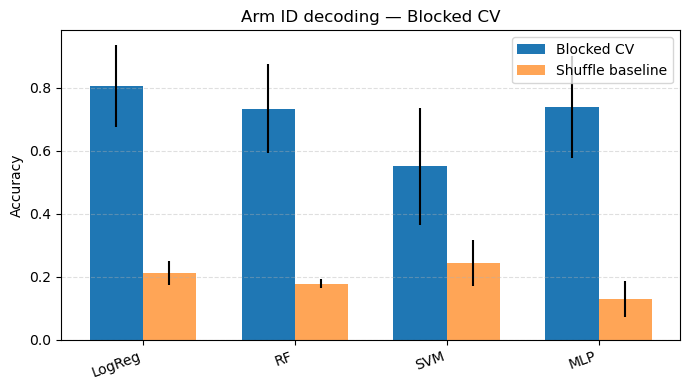

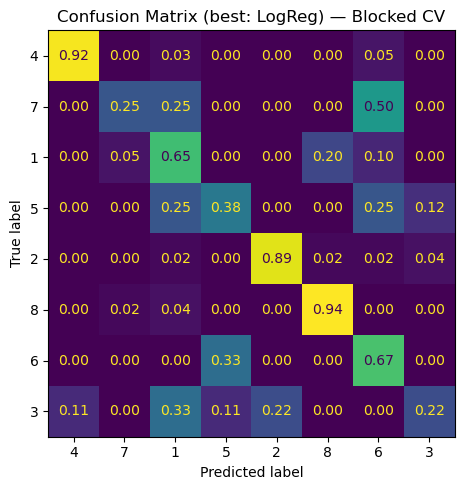

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, logging
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support, balanced_accuracy_score, f1_score

def arm_id_decoding_blocked_strict(event_matrices, arm_ids, *, n_blocks=5, min_spikes=100,
    target_len="median",      # "median" | int
    time_resize="pad",     # "pad" | "truncate"
    pca_dims=None, models=("LogReg","RF","SVM","MLP"), random_state=42, verbose=True):
    
    logger = logging.getLogger("arm_id_decoding_blocked_strict")
    logger.handlers.clear(); h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(h); logger.setLevel(logging.INFO if verbose else logging.WARNING)
    rng = np.random.RandomState(random_state)

    # validate
    events = list(event_matrices if not (isinstance(event_matrices,np.ndarray) and event_matrices.dtype==object) else event_matrices)
    y_raw = np.asarray(arm_ids); N = len(events)
    if len(y_raw)!=N: raise ValueError("arm_ids and event_matrices don't coincide.")
    valid = ~pd.isna(y_raw); events=[e for e,ok in zip(events,valid) if ok]; y_raw=y_raw[valid]; N=len(events)
    nset={M.shape[0] for M in events}
    if len(nset)!=1: raise ValueError(f"Mismo nº de neuronas requerido. Encontrados: {nset}")
    n_neurons=next(iter(nset))

    # classes in order of appearance
    seen=set(); classes=[]
    for v in y_raw:
        if v not in seen: seen.add(v); classes.append(v)
    classes=np.array(classes,dtype=object); map_idx={c:i for i,c in enumerate(classes)}
    y=np.array([map_idx[v] for v in y_raw],dtype=int); K=len(classes)

    # contiguous blocks
    if N < n_blocks: n_blocks=max(2,N)
    edges=np.linspace(0,N,n_blocks+1,dtype=int)
    blocks=[np.arange(edges[i],edges[i+1]) for i in range(n_blocks) if edges[i]<edges[i+1]]

    def _resize(M,T,how):
        n,t=M.shape
        if t==T: return M
        if how=="pad":
            out=np.zeros((n,T),float); take=min(t,T); out[:,:take]=M[:,:take]; return out
        if how=="truncate":
            return M[:,:min(t,T)]
        raise ValueError("time_resize invalid.")

    def _build_X(ev_list, keep_mask, T, how):
        rez=[_resize(M[keep_mask,:],T,how) for M in ev_list]
        return np.stack([M.reshape(-1) for M in rez],axis=0)

    # modelos
    zoo={"LogReg": LogisticRegression(max_iter=2000,class_weight="balanced",random_state=random_state,n_jobs=-1),
        "RF":     RandomForestClassifier(n_estimators=300,class_weight="balanced",random_state=random_state,n_jobs=-1),
        "SVM":    SVC(kernel="rbf",class_weight="balanced",random_state=random_state),
        "MLP":    MLPClassifier(hidden_layer_sizes=(128,),max_iter=1000,random_state=random_state,early_stopping=True)}
    zoo={k:v for k,v in zoo.items() if k in models}

    scores={k:[] for k in zoo}; shuf_scores={k:[] for k in zoo}
    y_pred_all={k:np.full(N,-1,int) for k in zoo}

    # --- CV ---
    for fi, te_idx in enumerate(blocks, start=1):
        tr_idx=np.setdiff1d(np.arange(N),te_idx,assume_unique=True)
        ev_tr=[events[j] for j in tr_idx]; ev_te=[events[j] for j in te_idx]
        y_tr,y_te=y[tr_idx],y[te_idx]

        # filter neurons only with train
        total=np.zeros(n_neurons,float)
        for M in ev_tr: total += np.nansum(M,axis=1,dtype=np.float64)
        keep= total >= float(min_spikes)
        if keep.sum()==0:
            if verbose: logger.warning(f"[Fold {fi}] 0 neuronas tras filtrar; fold ignorado.")
            continue

        # target_len only with train
        lens=np.array([M.shape[1] for M in ev_tr])
        T = int(np.median(lens)) if target_len=="median" else int(target_len)
        if T<1: raise ValueError("target_len invalid.")

        # build X
        X_tr=_build_X(ev_tr,keep,T,time_resize)
        X_te=_build_X(ev_te,keep,T,time_resize)

        # preproc only with train
        from sklearn.base import clone
        for name, base_clf in zoo.items():
            steps=[("scaler",StandardScaler())]
            if pca_dims is not None:
                n_comp=int(min(pca_dims,X_tr.shape[0],X_tr.shape[1])); 
                if n_comp>=1: steps.append(("pca",PCA(n_components=n_comp,random_state=random_state)))
            steps.append(("clf", clone(base_clf)))
            pipe=Pipeline(steps).fit(X_tr,y_tr)

            # eval (ignores non seen classes)
            cls_tr=set(np.unique(y_tr))
            m_eval=np.array([yt in cls_tr for yt in y_te],bool)
            if not m_eval.any(): continue
            X_te_eval, y_te_eval = X_te[m_eval], y_te[m_eval]

            y_hat=pipe.predict(X_te_eval)
            acc=accuracy_score(y_te_eval,y_hat)
            scores[name].append(acc)
            y_pred_all[name][te_idx[m_eval]] = y_hat

            # baseline: shuffled labels only on train
            y_tr_sh = rng.permutation(y_tr)
            pipe_sh=Pipeline(steps[:-1] + [("clf", clone(base_clf))]).fit(X_tr,y_tr_sh)
            acc_sh=accuracy_score(y_te_eval, pipe_sh.predict(X_te_eval))
            shuf_scores[name].append(acc_sh)

    acc={k:(float(np.mean(v)), float(np.std(v))) for k,v in scores.items() if len(v)}
    shuf={k:(float(np.mean(v)), float(np.std(v))) for k,v in shuf_scores.items() if len(v)}
    if not acc: raise RuntimeError("No valid folds.")

    best = max(acc.items(), key=lambda kv: kv[1][0])[0]
    y_pred = y_pred_all[best]; ok = y_pred!=-1
    labels_idx=np.arange(K)
    cm=confusion_matrix(y[ok],y_pred[ok],labels=labels_idx,normalize="true")

    # figures
    fig_acc, ax = plt.subplots(figsize=(7,4))
    names=list(acc.keys()); means=[acc[k][0] for k in names]; stds=[acc[k][1] for k in names]
    means_sh=[shuf[k][0] for k in names]; stds_sh=[shuf[k][1] for k in names]
    x=np.arange(len(names)); w=0.35
    ax.bar(x-w/2,means,w,yerr=stds,label="Blocked CV"); ax.bar(x+w/2,means_sh,w,yerr=stds_sh,alpha=0.7,label="Shuffle baseline")
    ax.set_xticks(x); ax.set_xticklabels(names,rotation=20,ha="right"); ax.set_ylabel("Accuracy"); ax.grid(axis="y",ls="--",alpha=0.4); ax.legend()
    ax.set_title("Arm ID decoding — Blocked CV"); fig_acc.tight_layout()

    fig_conf, ax2 = plt.subplots(figsize=(5.5,5))
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(ax=ax2, values_format=".2f", colorbar=False)
    ax2.set_title(f"Confusion Matrix (best: {best}) — Blocked CV"); fig_conf.tight_layout()

    # best metrics per class 
    prec, rec, f1, supp = precision_recall_fscore_support(y[ok], y_pred[ok], labels=labels_idx, zero_division=0)
    per_class_df = pd.DataFrame({"precision":prec,"recall":rec,"f1":f1,"support":supp}, index=classes)
    global_metrics = {"accuracy": float((y[ok]==y_pred[ok]).mean()),
        "balanced_accuracy": float(balanced_accuracy_score(y[ok], y_pred[ok])),
        "macro_f1": float(f1_score(y[ok], y_pred[ok], average="macro")),
        "weighted_f1": float(f1_score(y[ok], y_pred[ok], average="weighted")),}
    
    return (acc, shuf, fig_acc, fig_conf, per_class_df, global_metrics)


accuracies, shuffled_accuracies, fig_acc, fig_conf, per_class_df, global_metrics = arm_id_decoding_blocked_strict(event_matrices, event_arm_ids, n_blocks=5, min_spikes=100,
    target_len="median", time_resize="pad", pca_dims=None, models=("LogReg","RF","SVM","MLP"), random_state=42, verbose=True)

In [ ]:
# decoding pipeline
"""
End-to-end, time-aware decoding pipeline with robust temporal normalization and duration outlier filtering.

This cell provides:
- Metrics utilities: Wilson CI for accuracy, bootstrap CI for macro-F1, permutation-test p-value.
- Time helpers: resize/truncate/pad of event matrices (neurons × time).
- Robust duration outlier filtering (MAD-based by default).
- A full function `rf_blockcv_grid_with_holdout_robust` that:
  * Applies chronological holdouts with a temporal GAP.
  * Runs inner blocked CV to tune a Random Forest (train-only preprocessing, no leakage).
  * Supports TWO new time-normalization modes:
      1) T = median - 1 std  (truncate all to this T)       -> target_len="median_minus_std"
      2) T = median          (pad short events with zeros)  -> target_len="median_pad"
  * Reports OOF metrics, sanity baselines (shuffle/rotate), per-neuron importances (if no PCA),
    TEST metrics with Wilson/Bootstrap CIs and a permutation-test p-value.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from dataclasses import dataclass

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
    confusion_matrix,               # imported for convenience; not used in core code
    ConfusionMatrixDisplay,         # imported for convenience; not used in core code
    precision_recall_fscore_support,
    balanced_accuracy_score, f1_score)

# Metrics utilities

def wilson_ci(k, n, alpha=0.05):
    """
    Wilson score interval for a binomial proportion (accuracy).
    Preferable to normal approximation, especially for moderate/low n.
    Returns (lower, upper). If n == 0, returns (nan, nan).
    """
    if n == 0:
        return (np.nan, np.nan)
    from math import sqrt
    from scipy.stats import norm
    z = norm.ppf(1 - alpha/2)
    phat = k / n
    denom = 1 + z**2 / n
    centre = phat + z*z / (2*n)
    adj = z * np.sqrt((phat*(1 - phat) + z*z/(4*n)) / n)
    lower = (centre - adj) / denom
    upper = (centre + adj) / denom
    return float(lower), float(upper)

def bootstrap_ci_macro_f1(y_true, y_pred, B=1000, alpha=0.05, rng=None):
    """
    Non-parametric bootstrap CI for macro-F1.
    Resamples indices with replacement B times, computes macro-F1 on each,
    and returns the (alpha/2, 1 - alpha/2) percentiles.
    """
    rng = np.random.RandomState(0) if rng is None else rng
    n = len(y_true)
    if n == 0:
        return (np.nan, np.nan)
    vals = []
    for _ in range(int(B)):
        idx = rng.randint(0, n, n)
        vals.append(f1_score(y_true[idx], y_pred[idx], average="macro"))
    lo, hi = np.percentile(vals, [100*alpha/2, 100*(1 - alpha/2)])
    return float(lo), float(hi)

def permutation_test_accuracy(X_tr, y_tr, X_te, y_te, clf, n_perm=1000, rng=None):
    """
    Permutation test for accuracy on TEST:
    - Fit clf on (X_tr, y_tr).
    - Compute accuracy on true (X_te, y_te).
    - Permute y_te many times; compute accuracy each time.
    - p-value = (# permuted accuracies >= real accuracy + 1) / (n_perm + 1).
      (Add-one smoothing in the style of Westfall–Young.)
    Returns (acc_real, p_value).
    """
    rng = np.random.RandomState(0) if rng is None else rng
    clf.fit(X_tr, y_tr)
    acc_real = accuracy_score(y_te, clf.predict(X_te))
    cnt = 0
    for _ in range(int(n_perm)):
        y_te_perm = rng.permutation(y_te)
        acc_p = accuracy_score(y_te_perm, clf.predict(X_te))
        if acc_p >= acc_real:
            cnt += 1
    pval = (cnt + 1) / (n_perm + 1)
    return float(acc_real), float(pval)


# Time/data helpers
def _resize_time(M, T, how):
    """
    Resize (neurons x time) to have exactly T columns.

    Modes:
      - "interp": linear interpolation to length T.
      - "pad":    truncate if longer; zero-pad if shorter -> width T.
      - "truncate": (FIX) also ensure width T by truncating long and zero-padding short.
                     This avoids shape mismatches during stacking/scaling.
    """
    n, t = M.shape
    if t == T:
        return M

    if how == "interp":
        src = np.linspace(0, t-1, t)
        dst = np.linspace(0, t-1, T)
        out = np.empty((n, T), float)
        for i in range(n):
            out[i] = np.interp(dst, src, M[i])
        return out

    if how in ("pad", "truncate"):
        # Both guarantee exactly T columns:
        # - take = min(t, T) copies what exists
        # - if event is shorter than T, the tail stays zero
        out = np.zeros((n, T), float)
        take = min(t, T)
        out[:, :take] = M[:, :take]
        return out

    raise ValueError("time_resize must be 'interp' | 'pad' | 'truncate'.")


def _build_X(ev_list, keep_mask, T, how):
    """
    For a list of events (each an array of shape (neurons, time)):
      - Select kept neurons (keep_mask).
      - Resize each event to length T using `how`.
      - Flatten to 1D and stack into a design matrix X of shape (n_events, kept_neurons*T).
    """
    rez = [_resize_time(M[keep_mask, :], T, how) for M in ev_list]
    return np.stack([M.reshape(-1) for M in rez], axis=0)

def _filter_length_outliers(events, method="mad", thresh=6.0, logger=None):
    """
    Robustly discard events with extreme duration outliers.

    Parameters
    ----------
    events : list of np.ndarray
        Each event is (neurons × time).
    method : {"mad", "iqr", "std"}
        - "mad": robust z-score via median absolute deviation (recommended).
        - "iqr": keep within [Q1 - thresh*IQR, Q3 + thresh*IQR].
        - "std": keep within mean ± thresh*std (less robust).
    thresh : float
        Larger => more permissive.
        For "mad", typical robust thresholds: 5..7 (6.0 default is quite conservative).
    logger : logging.Logger or None

    Returns
    -------
    keep : boolean array of shape (len(events),)
        True = keep this event, False = outlier by duration.
    """
    lens = np.array([M.shape[1] for M in events], dtype=int)
    med = float(np.median(lens))
    if method == "mad":
        mad = float(np.median(np.abs(lens - med)))
        mad = mad if mad > 0 else 1.0  # avoid division by zero
        rzs = 0.6745 * (lens - med) / mad  # robust z-score: 0.6745 ~= Phi^{-1}(0.75)
        keep = np.abs(rzs) <= float(thresh)
    elif method == "iqr":
        q1, q3 = np.percentile(lens, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - thresh * iqr, q3 + thresh * iqr
        keep = (lens >= lo) & (lens <= hi)
    else:  # "std"
        mu, sd = float(np.mean(lens)), float(np.std(lens))
        sd = sd if sd > 0 else 1.0
        keep = np.abs(lens - mu) <= thresh * sd

    if logger is not None and (~keep).any():
        bad_idx = np.where(~keep)[0]
        logger.warning(
            f"Discarding {bad_idx.size} duration-outlier events "
            f"(median={med:.1f}, method={method}, thresh={thresh}). idx={bad_idx.tolist()}")
    return keep

def _compute_T_from_lens(lens, target_len):
    """
    Determine target T from TRAIN lengths according to the requested mode.

    Modes (strings):
      - "median" (default): T = median(lengths)
      - "median_pad":       T = median(lengths), then pad shorter events with zeros
      - "median_truncate":  T = median(lengths), then truncate longer events
      - "median_minus_std" (or "median_minus_1std"): T = floor(median - std), then truncate
    Or pass an integer to set a fixed T.

    Notes:
      * T is computed ONLY from training lengths to avoid leakage.
      * We ensure T >= 1.
    """
    if isinstance(target_len, str):
        if target_len in ("median", "median_pad", "median_truncate"):
            return int(max(1, np.round(np.median(lens))))
        if target_len in ("median_minus_std", "median_minus_1std"):
            return int(max(1, np.floor(np.median(lens) - np.std(lens))))
        raise ValueError(f"Unrecognized target_len='{target_len}'.")
    # numeric target_len
    return int(max(1, int(target_len)))


# Results type         

@dataclass
class HoldoutResult:
    split_id: int
    holdout_frac: float
    gap: int
    best_params: dict
    cv_metrics: dict
    sanity: dict
    test_metrics: dict
    test_ci: dict
    per_class_test: pd.DataFrame


# Main decoding function    

def rf_blockcv_grid_with_holdout_robust(event_matrices, arm_ids, *,
    order_index=None, n_blocks_inner=5, holdout_fracs=(0.15, 0.20, 0.25),
    gap=5,                       # buffer events between TRAIN+VAL and TEST (to break autocorrelation)
    min_spikes=100,              # drop neurons with fewer total spikes in TRAIN fold
    target_len="median_pad",         # supports median_pad", "median_minus_std"
    time_resize="pad",           
    pca_dims=None, random_state=42, verbose=True, param_grid=None,
    n_sanity_shuffles=3, rotate_fraction=0.2,
    n_perm_test=1000,            # permutations on TEST for p-value
    duration_outlier_method="mad",   # robust filtering mode ("mad" recommended)
    duration_outlier_thresh=6.0      # higher => more permissive; 6.0 is conservative
):
    """
    Random-Forest decoder with time-aware evaluation, robust time normalization, and uncertainty quantification.

    Key features:
      - Multiple chronological holdouts (e.g., 15%, 20%, 25%) with a temporal GAP.
      - Inner blocked CV on TRAIN+VAL to tune hyperparameters (no leakage).
      - Train-only preprocessing: neuron filtering, time normalization (T), scaler, and PCA.
      - Temporal normalization options:
          * "median_minus_std":  T = median - 1 std, truncate all events to T.
          * "median_pad":        T = median, pad shorter events with zeros; truncate longer ones.
      - Duration outlier filtering (MAD-based by default) applied globally before splitting.
      - OOF metrics on TRAIN+VAL, sanity baselines (shuffle / temporal rotate),
        optional neuron importances (if no PCA).
      - Final TEST metrics with Wilson CI (accuracy), bootstrap CI (macro-F1), and a permutation-test p-value.

    Returns:
      List[HoldoutResult], one per holdout fraction actually evaluated.
    """
    # ---------- logging ----------
    logger = logging.getLogger("rf_blockcv_grid_with_holdout_robust")
    logger.handlers.clear()
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(h)
    logger.setLevel(logging.INFO if verbose else logging.WARNING)
    rng = np.random.RandomState(random_state)

    # prepare inputs 
    # Accept either list or object-dtype ndarray of events
    events = list(event_matrices if not (isinstance(event_matrices, np.ndarray) and event_matrices.dtype == object)
                  else event_matrices)
    y_raw = np.asarray(arm_ids)
    N = len(events)
    if len(y_raw) != N:
        raise ValueError("arm_ids and event_matrices length mismatch.")
    if order_index is not None:
        # Optional explicit chronological ordering
        order_index = np.asarray(order_index, int)
        events = [events[i] for i in order_index]
        y_raw = y_raw[order_index]

    # Consistent neuron count across events
    nset = {M.shape[0] for M in events}
    if len(nset) != 1:
        raise ValueError(f"All events must have the same number of neurons. Found: {nset}")
    n_neurons = next(iter(nset))

    # Map original labels -> 0..K-1 while keeping the class order of first occurrence
    seen, classes = set(), []
    for v in y_raw:
        if v not in seen:
            seen.add(v)
            classes.append(v)
    classes = np.array(classes, dtype=object)
    y_all = np.array([np.where(classes == v)[0][0] for v in y_raw], dtype=int)
    K = len(classes)

    # global duration outlier filtering 
    keep_len = _filter_length_outliers(events, method=duration_outlier_method, thresh=duration_outlier_thresh, logger=logger)
    
    if not np.all(keep_len):
        events = [e for e, k in zip(events, keep_len) if k]
        y_all = y_all[keep_len]
        y_raw = y_raw[keep_len]
        N = len(events)
        if verbose:
            logger.info(f"{N} events remain after duration-outlier filtering.")

    # default hyperparameter grid 
    if param_grid is None:
        param_grid = [{"n_estimators": ne, "max_depth": md, "min_samples_leaf": msl, "max_features": mf}
            for ne in [200, 400]
            for md in [None, 20]
            for msl in [1, 2]
            for mf in ["sqrt", 0.5]]

    results = []
    split_id = 0

    
    # Iterate over holdouts      
    for frac in holdout_fracs:
        frac = float(np.clip(frac, 0.05, 0.5))  # keep reasonable test fractions
        n_test = max(1, int(round(N * frac)))
        n_trainval = max(2, N - n_test - int(gap))
        if n_trainval < 2:
            logger.warning(f"holdout_frac={frac:.2f} + gap={gap} leaves too little TRAIN+VAL; skipping.")
            continue

        # Chronological split with GAP
        idx_trval = np.arange(0, n_trainval)
        idx_gap   = np.arange(n_trainval, n_trainval + int(gap))
        idx_test  = np.arange(n_trainval + int(gap), N)

        logger.info(f"[Split {split_id}] TRAIN+VAL={len(idx_trval)}, GAP={len(idx_gap)}, TEST={len(idx_test)} "
                    f"(frac={frac:.2f}).")

        ev_trval = [events[i] for i in idx_trval]
        y_trval  = y_all[idx_trval]
        ev_test  = [events[i] for i in idx_test]
        y_test_all = y_all[idx_test]

        # INNER: Blocked CV for hyperparameter tuning 
        Ntr = len(ev_trval)
        n_blocks_inner_eff = int(max(2, min(n_blocks_inner, Ntr)))
        edges = np.linspace(0, Ntr, n_blocks_inner_eff + 1, dtype=int)
        inner_blocks = [np.arange(edges[i], edges[i+1]) for i in range(n_blocks_inner_eff) if edges[i] < edges[i+1]]

        scores_per_param = [[] for _ in param_grid]

        # Evaluate each grid point via blocked CV
        for te_idx in inner_blocks:
            tr_idx = np.setdiff1d(np.arange(Ntr), te_idx, assume_unique=True)

            ev_tr = [ev_trval[j] for j in tr_idx]
            ev_te = [ev_trval[j] for j in te_idx]
            y_tr  = y_trval[tr_idx]
            y_te  = y_trval[te_idx]

            # --- TRAIN-ONLY neuron filtering ---
            total = np.zeros(n_neurons, float)
            for M in ev_tr:
                total += np.nansum(M, axis=1, dtype=np.float64)
            keep = total >= float(min_spikes)
            if keep.sum() == 0:
                continue  # no usable neurons in this fold

            # --- TRAIN-ONLY time normalization T ---
            lens = np.array([M.shape[1] for M in ev_tr])
            T = _compute_T_from_lens(lens, target_len)
            if T < 1:
                continue

            # Choose effective resize mode based on target_len
            time_resize_eff = time_resize
            if isinstance(target_len, str):
                if target_len == "median_pad":
                    time_resize_eff = "pad"        # pad short events with zeros
                if target_len in ("median_minus_std"):
                    time_resize_eff = "truncate"   # truncate longer events

            # Build X (train/val) with the same neurons and T
            X_tr = _build_X(ev_tr, keep, T, time_resize_eff)
            X_te = _build_X(ev_te, keep, T, time_resize_eff)

            # TRAIN-ONLY scaler (+ PCA optional)
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)
            X_te_s = scaler.transform(X_te)

            if pca_dims is not None:
                n_comp = int(min(pca_dims, X_tr_s.shape[0], X_tr_s.shape[1]))
                if n_comp >= 1:
                    pca = PCA(n_components=n_comp, random_state=random_state).fit(X_tr_s)
                    X_tr_s = pca.transform(X_tr_s)
                    X_te_s = pca.transform(X_te_s)

            # Evaluate only classes present in TRAIN for this fold
            cls_tr = set(np.unique(y_tr))
            mask_eval = np.array([yt in cls_tr for yt in y_te], bool)
            if not mask_eval.any():
                continue
            Xe, ye = X_te_s[mask_eval], y_te[mask_eval]

            # Grid search scoring = accuracy on the validation block
            for pi, params in enumerate(param_grid):
                rf = RandomForestClassifier(**params, class_weight="balanced", random_state=random_state, n_jobs=-1)
                rf.fit(X_tr_s, y_tr)
                scores_per_param[pi].append(accuracy_score(ye, rf.predict(Xe)))

        # Aggregate CV scores and pick best params
        rows = []
        for i, (params, scores) in enumerate(zip(param_grid, scores_per_param)):
            m = float(np.mean(scores)) if scores else np.nan
            s = float(np.std(scores))  if scores else np.nan
            row = {"grid_id": i, "mean_acc": m, "std_acc": s}
            row.update(params)
            rows.append(row)
        results_cv_df = pd.DataFrame(rows).sort_values("mean_acc", ascending=False, na_position="last").reset_index(drop=True)
        best_idx = int(results_cv_df.iloc[0]["grid_id"])
        best_params = param_grid[best_idx]

        # Second INNER pass: OOF predictions + sanity + importances 
        y_pred_oof = np.full(Ntr, -1, int)
        sanity_shuf, sanity_rot = [], []
        neuron_imp_sum = np.zeros(n_neurons, float)
        neuron_imp_cnt = np.zeros(n_neurons, int)
        roll_k = max(1, int(round(Ntr * float(rotate_fraction))))

        for te_idx in inner_blocks:
            tr_idx = np.setdiff1d(np.arange(Ntr), te_idx, assume_unique=True)

            ev_tr = [ev_trval[j] for j in tr_idx]
            ev_te = [ev_trval[j] for j in te_idx]
            y_tr  = y_trval[tr_idx]
            y_te  = y_trval[te_idx]

            # TRAIN-ONLY neuron filtering
            total = np.zeros(n_neurons, float)
            for M in ev_tr:
                total += np.nansum(M, axis=1, dtype=np.float64)
            keep = total >= float(min_spikes)
            if keep.sum() == 0:
                continue
            kept_idx = np.where(keep)[0]

            # TRAIN-ONLY T
            lens = np.array([M.shape[1] for M in ev_tr])
            T = _compute_T_from_lens(lens, target_len)
            if T < 1:
                continue

            # Effective time resize mode
            time_resize_eff = time_resize
            if isinstance(target_len, str):
                if target_len == "median_pad":
                    time_resize_eff = "pad"
                if target_len in ("median_minus_std"):
                    time_resize_eff = "truncate"

            # Build X
            X_tr = _build_X(ev_tr, keep, T, time_resize_eff)
            X_te = _build_X(ev_te, keep, T, time_resize_eff)

            # Scaler + optional PCA (fit on TRAIN only)
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)
            X_te_s = scaler.transform(X_te)

            map_imp = True
            if pca_dims is not None:
                n_comp = int(min(pca_dims, X_tr_s.shape[0], X_tr_s.shape[1]))
                if n_comp >= 1:
                    pca = PCA(n_components=n_comp, random_state=random_state).fit(X_tr_s)
                    X_tr_s = pca.transform(X_tr_s)
                    X_te_s = pca.transform(X_te_s)
                    map_imp = False  # cannot map feature importances back to neurons when PCA is used

            # Evaluate only seen classes
            cls_tr = set(np.unique(y_tr))
            mask_eval = np.array([yt in cls_tr for yt in y_te], bool)
            if not mask_eval.any():
                continue
            Xe, ye, idx_eval = X_te_s[mask_eval], y_te[mask_eval], np.where(mask_eval)[0]

            # Fit RF with best params; OOF predictions
            rf = RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr)
            y_hat = rf.predict(Xe)
            y_pred_oof[te_idx[idx_eval]] = y_hat

            # (Optional) neuron-level importances if no PCA
            if map_imp and hasattr(rf, "feature_importances_"):
                try:
                    # Feature vector length = kept_neurons * T; sum over time to get per-neuron importance
                    fi = rf.feature_importances_.reshape(len(kept_idx), T).sum(axis=1)
                    neuron_imp_sum[kept_idx] += fi
                    neuron_imp_cnt[kept_idx] += 1
                except Exception:
                    pass

            # Sanity 1: label shuffle (TRAIN)
            for _ in range(int(n_sanity_shuffles)):
                y_tr_sh = rng.permutation(y_tr)
                rf_sh = RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr_sh)
                sanity_shuf.append(accuracy_score(ye, rf_sh.predict(Xe)))

            # Sanity 2: temporal rotation of labels
            y_rot_all = np.roll(y_trval, roll_k)
            y_tr_rot = y_rot_all[tr_idx]
            rf_rot = RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr_rot)
            sanity_rot.append(accuracy_score(ye, rf_rot.predict(Xe)))

        # Collect OOF metrics (only where we produced predictions)
        ok_cv = y_pred_oof != -1
        cv_metrics = {"accuracy": float((y_trval[ok_cv] == y_pred_oof[ok_cv]).mean()) if ok_cv.any() else np.nan,
            "balanced_accuracy": float(balanced_accuracy_score(y_trval[ok_cv], y_pred_oof[ok_cv])) if ok_cv.any() else np.nan,
            "macro_f1": float(f1_score(y_trval[ok_cv], y_pred_oof[ok_cv], average="macro")) if ok_cv.any() else np.nan,
            "weighted_f1": float(f1_score(y_trval[ok_cv], y_pred_oof[ok_cv], average="weighted")) if ok_cv.any() else np.nan,}
        
        sanity = {"shuffle_mean": float(np.mean(sanity_shuf)) if len(sanity_shuf) else np.nan,
            "shuffle_std":  float(np.std(sanity_shuf)) if len(sanity_shuf) else np.nan,
            "rotate_mean":  float(np.mean(sanity_rot)) if len(sanity_rot) else np.nan,
            "rotate_std":   float(np.std(sanity_rot)) if len(sanity_rot) else np.nan,}

        # FINAL TEST (with GAP) 
        # TRAIN+VAL-only preprocessing
        total = np.zeros(n_neurons, float)
        for M in ev_trval:
            total += np.nansum(M, axis=1, dtype=np.float64)
        keep_trval = total >= float(min_spikes)
        if keep_trval.sum() == 0:
            raise ValueError("0 neurons left after filtering in TRAIN+VAL; decrease 'min_spikes'.")

        lens_trval = np.array([M.shape[1] for M in ev_trval])
        T_trval = _compute_T_from_lens(lens_trval, target_len)
        if T_trval < 1:
            raise ValueError("Invalid target_len produced T < 1.")

        time_resize_eff = time_resize
        if isinstance(target_len, str):
            if target_len == "median_pad":
                time_resize_eff = "pad"
            if target_len in ("median_minus_std"):
                time_resize_eff = "truncate"

        X_trval = _build_X(ev_trval, keep_trval, T_trval, time_resize_eff)
        X_test  = _build_X(ev_test,  keep_trval, T_trval, time_resize_eff)

        scaler = StandardScaler().fit(X_trval)
        X_trval_s = scaler.transform(X_trval)
        X_test_s  = scaler.transform(X_test)

        if pca_dims is not None:
            n_comp = int(min(pca_dims, X_trval_s.shape[0], X_trval_s.shape[1]))
            if n_comp >= 1:
                pca = PCA(n_components=n_comp, random_state=random_state).fit(X_trval_s)
                X_trval_s = pca.transform(X_trval_s)
                X_test_s  = pca.transform(X_test_s)

        # Exclude TEST samples with classes unseen in TRAIN+VAL
        cls_trval = set(np.unique(y_trval))
        mask_eval_test = np.array([yt in cls_trval for yt in y_test_all], bool)
        X_te_eval = X_test_s[mask_eval_test]
        y_te_eval = y_test_all[mask_eval_test]

        # Fit final RF and evaluate
        rf_final = RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_trval_s, y_trval)
        y_hat_test = rf_final.predict(X_te_eval)

        # Metrics + CIs
        acc = float(accuracy_score(y_te_eval, y_hat_test)) if len(y_te_eval) else np.nan
        k_correct = int((y_te_eval == y_hat_test).sum())
        n_eval = int(len(y_te_eval))
        acc_lo, acc_hi = wilson_ci(k_correct, n_eval, alpha=0.05)

        mf1 = float(f1_score(y_te_eval, y_hat_test, average="macro")) if len(y_te_eval) else np.nan
        mf1_lo, mf1_hi = bootstrap_ci_macro_f1(y_te_eval, y_hat_test, B=2000, alpha=0.05, rng=rng)

        # Permutation test on TEST (re-train a local clone to be consistent)
        acc_real, p_perm = permutation_test_accuracy(X_trval_s, y_trval, X_te_eval, y_te_eval,
            RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1), n_perm=n_perm_test, rng=rng)

        # Per-class table (index with original classes)
        per_class_df = pd.DataFrame(np.vstack(precision_recall_fscore_support(y_te_eval, y_hat_test,
                                                      labels=np.arange(K), zero_division=0)).T, columns=["precision", "recall", "f1", "support"])
        per_class_df.index = classes  # note: some classes may have support=0 in this split

        test_metrics = {"accuracy": acc, "balanced_accuracy": float(balanced_accuracy_score(y_te_eval, y_hat_test)) if len(y_te_eval) else np.nan,
            "macro_f1": mf1, "weighted_f1": float(f1_score(y_te_eval, y_hat_test, average="weighted")) if len(y_te_eval) else np.nan, "perm_pvalue": float(p_perm)}
        
        test_ci = {"accuracy_wilson": (acc_lo, acc_hi), "macro_f1_bootstrap": (mf1_lo, mf1_hi), "n_test_samples": int(n_eval)}

        results.append(HoldoutResult(split_id=split_id, holdout_frac=frac, gap=int(gap), best_params=best_params, cv_metrics=cv_metrics, sanity=sanity, test_metrics=test_metrics, test_ci=test_ci, per_class_test=per_class_df))
        
        split_id += 1

    return results

In [6]:
# Example 1: Truncate at (median), all arms
results_pp_all = rf_blockcv_grid_with_holdout_robust(event_matrices, event_arm_ids, target_len="median_pad", time_resize="truncate",          
    duration_outlier_method="mad", duration_outlier_thresh=6.0, random_state=42, verbose=True)

print("Neural pp-only all arms TEST:", results_pp_all[0].test_metrics)

[WARNING] Discarding 2 duration-outlier events (median=67.0, method=mad, thresh=6.0). idx=[22, 122]
[INFO] 178 events remain after duration-outlier filtering.
[INFO] [Split 0] TRAIN+VAL=146, GAP=5, TEST=27 (frac=0.15).
[INFO] [Split 1] TRAIN+VAL=137, GAP=5, TEST=36 (frac=0.20).
[INFO] [Split 2] TRAIN+VAL=129, GAP=5, TEST=44 (frac=0.25).


Neural pp-only all arms TEST: {'accuracy': 0.9259259259259259, 'balanced_accuracy': 0.7, 'macro_f1': 0.6882352941176471, 'weighted_f1': 0.9084967320261439, 'perm_pvalue': 0.000999000999000999}


In [7]:
# Example 2: Truncate at (median), only rewarded arms
results_pp_rewarded = rf_blockcv_grid_with_holdout_robust(event_matrices_rewarded, arm_ids_rewarded, target_len="median_pad", duration_outlier_method="mad", 
                                                          duration_outlier_thresh=6.0, random_state=42, verbose=True)

# Table of results:
table_pp_rewarded = pd.DataFrame([{"split": r.split_id, "holdout_frac": r.holdout_frac,
    "gap": r.gap, "acc": r.test_metrics["accuracy"], "acc_CI": r.test_ci["accuracy_wilson"],
    "macro_f1": r.test_metrics["macro_f1"], "macro_f1_CI": r.test_ci["macro_f1_bootstrap"],
    "perm_p": r.test_metrics["perm_pvalue"],
    "cv_acc": r.cv_metrics["accuracy"], "sanity_shuffle": r.sanity["shuffle_mean"],
    "sanity_rotate": r.sanity["rotate_mean"], "best_params": r.best_params} for r in results_pp_rewarded])

print(table_pp_rewarded)

[WARNING] Discarding 1 duration-outlier events (median=68.0, method=mad, thresh=6.0). idx=[11]
[INFO] 132 events remain after duration-outlier filtering.
[INFO] [Split 0] TRAIN+VAL=107, GAP=5, TEST=20 (frac=0.15).
[INFO] [Split 1] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 2] TRAIN+VAL=94, GAP=5, TEST=33 (frac=0.25).


   split  holdout_frac  gap       acc  \
0      0          0.15    5  1.000000   
1      1          0.20    5  1.000000   
2      2          0.25    5  0.969697   

                                    acc_CI  macro_f1  \
0                (0.8388748419471806, 1.0)  1.000000   
1                (0.8712710781407846, 1.0)  1.000000   
2  (0.846812746178811, 0.9946305894631283)  0.969634   

                 macro_f1_CI    perm_p    cv_acc  sanity_shuffle  \
0                 (1.0, 1.0)  0.000999  0.934579        0.378211   
1                 (1.0, 1.0)  0.000999  0.950495        0.406667   
2  (0.8944444444444445, 1.0)  0.000999  0.904255        0.347758   

   sanity_rotate                                        best_params  
0       0.226407  {'n_estimators': 400, 'max_depth': 20, 'min_sa...  
1       0.385714  {'n_estimators': 200, 'max_depth': None, 'min_...  
2       0.510526  {'n_estimators': 200, 'max_depth': None, 'min_...  


In [9]:
def events_from_neur_ev_pos(tensor_neur_ev_pos):
    """
    Input: tensor (neurons, events, position)
    Output: list of (neurons x position) matrices, one per event
    """
    n, E, P = tensor_neur_ev_pos.shape
    return [tensor_neur_ev_pos[:, i, :] for i in range(E)]

events = events_from_neur_ev_pos(tensorNEP_all100pp)  # converts tensor (neurons,events,position) to a list of (neurons x position) matrices per event
results_all_pp_NEP = rf_blockcv_grid_with_holdout_robust(events, event_arm_ids,
    target_len="median_pad",          # T = median, pad short events, truncate long ones
    duration_outlier_method="mad", duration_outlier_thresh=6.0, random_state=42, verbose=True)

print("Neural pp-only all arms from tensor NEP TEST:", results_all_pp_NEP[0].test_metrics)

events_rewarded = events_from_neur_ev_pos(tensorNEP_rewarded100pp) 
results_rewarded_pp_NEP = rf_blockcv_grid_with_holdout_robust(events_rewarded, event_arm_ids_rewarded,
    target_len="median_pad",          # T = median, pad short events, truncate long ones
    duration_outlier_method="mad", duration_outlier_thresh=6.0, random_state=42, verbose=True)

print("Neural pp-only rewarded arms from tensor NEP TEST:", results_rewarded_pp_NEP[0].test_metrics)

[INFO] [Split 0] TRAIN+VAL=148, GAP=5, TEST=27 (frac=0.15).
[INFO] [Split 1] TRAIN+VAL=139, GAP=5, TEST=36 (frac=0.20).
[INFO] [Split 2] TRAIN+VAL=130, GAP=5, TEST=45 (frac=0.25).
[INFO] [Split 0] TRAIN+VAL=108, GAP=5, TEST=20 (frac=0.15).


Neural pp-only all arms from tensor NEP TEST: {'accuracy': 0.7777777777777778, 'balanced_accuracy': 0.675, 'macro_f1': 0.6133333333333333, 'weighted_f1': 0.7604938271604937, 'perm_pvalue': 0.000999000999000999}


[INFO] [Split 1] TRAIN+VAL=101, GAP=5, TEST=27 (frac=0.20).
[INFO] [Split 2] TRAIN+VAL=95, GAP=5, TEST=33 (frac=0.25).


Neural pp-only rewarded arms from tensor NEP TEST: {'accuracy': 0.8, 'balanced_accuracy': 0.8095238095238096, 'macro_f1': 0.7833333333333333, 'weighted_f1': 0.7849999999999999, 'perm_pvalue': 0.000999000999000999}


In [12]:
# Behavior-event matrices (polar) with median-length normalization

# What this function does:
#   1) Extracts per-event features in polar coordinates from whl[['x1','y1']] at the tracker’s native sampling (uses interpolation ONLY to
#      sample the continuous trajectory at regular dt if event edges cut between samples — this is unavoidable).
#   2) Computes the median event length (in samples) among NON-outlier events.
#   3) Normalizes every kept event to EXACT width T = median:
#        - truncate longer events to T,
#        - zero-pad shorter events up to T.
#   4) Discards duration outliers using the SAME robust policy as the pipeline.
#
# Return:
#   - behavior_matrices : list[np.ndarray or None]  # shape (n_features, T) or None if dropped
#   - kept_mask         : np.ndarray (bool)         # after outlier filtering
#   - lengths           : list[int]                 # ORIGINAL per-event length BEFORE normalization
#   - feature_names     : list[str]
#
# Notes:
#   - Final width T is constant across events, so downstream _build_X will just pass through (already equal-length), 
#     or re-normalize if you choose a different T per split in the decoding pipeline.

import numpy as np
import pandas as pd

# Fallback: use pipeline's _resize_time if present; otherwise define a safe version
try:
    _resize_time  # noqa: F401
except NameError:
    def _resize_time(M, T, how):
        """
        Ensure EXACT width T along axis=1.
        - "interp": linear interpolation to T.
        - "pad":    truncate long, zero-pad short -> width T.
        - "truncate": same as "pad" here (truncate long, zero-pad short) to guarantee stacking.
        """
        n, t = M.shape
        if t == T:
            return M
        if how == "interp":
            src = np.linspace(0, t-1, t)
            dst = np.linspace(0, t-1, T)
            out = np.empty((n, T), float)
            for i in range(n):
                out[i] = np.interp(dst, src, M[i])
            return out
        if how in ("pad", "truncate"):
            out = np.zeros((n, T), float)
            take = min(t, T)
            out[:, :take] = M[:, :take]
            return out
        raise ValueError("time_resize must be 'interp' | 'pad' | 'truncate'.")

# helpers
def _infer_time_ms_from_index(index, fs_hz=39.0625):
    if isinstance(index, pd.DatetimeIndex):
        t0 = index[0]
        return (index - t0) / pd.Timedelta(milliseconds=1)
    idx = np.asarray(index, dtype=float)
    d = np.median(np.diff(idx))
    dt_ms = 1000.0 / fs_hz
    if abs(d - 1.0/fs_hz) < 1e-3:   # seconds at ~39 Hz
        return (idx - idx[0]) * 1000.0
    if abs(d - dt_ms) < 1.0:        # milliseconds
        return (idx - idx[0])
    if abs(d - 1.0) < 0.1:          # sample indices
        return (idx - idx[0]) * dt_ms
    return (idx - idx[0]) * 1000.0  # fallback: seconds

def _safe_fill_series(s: pd.Series):
    s2 = s.astype(float).copy()
    s2.replace([np.inf, -np.inf], np.nan, inplace=True)
    try:
        s2 = s2.interpolate(method="time") if isinstance(s2.index, pd.DatetimeIndex) else s2.interpolate()
    except Exception:
        s2 = s2.interpolate()
    s2 = s2.ffill().bfill().fillna(0.0)
    return s2

def _polar_features(x, y, add_derivatives=False):
    # Center at origin; if your maze center is known, subtract (x0,y0) before calling via `center=(x0,y0)`
    r = np.hypot(x, y)
    theta = np.arctan2(y, x)
    s, c = np.sin(theta), np.cos(theta)

    if not add_derivatives:
        feats = np.vstack([r, s, c])
        names = ["r", "sin_theta", "cos_theta"]
        feats[~np.isfinite(feats)] = 0.0
        return feats, names

    # finite-difference (same length using prepend)
    dr = np.diff(r, prepend=r[0])
    ds = np.diff(s, prepend=s[0])
    dc = np.diff(c, prepend=c[0])
    feats = np.vstack([r, dr, s, c, ds, dc])
    names = ["r", "dr", "sin_theta", "cos_theta", "d_sin_theta", "d_cos_theta"]
    feats[~np.isfinite(feats)] = 0.0
    return feats, names

# Optional: reuse the pipeline’s robust duration outlier filter if available
def _length_outlier_mask_from_lengths(lengths, method="mad", thresh=6.0):
    """
    Robust mask for lengths (1=keep, 0=outlier) using MAD/IQR/STD.
    Mirrors the logic of _filter_length_outliers but operates on raw lengths.
    """
    L = np.asarray(lengths, dtype=float)
    if L.size == 0:
        return np.array([], dtype=bool)

    if method == "mad":
        med = np.median(L)
        mad = np.median(np.abs(L - med))
        mad = mad if mad > 0 else 1.0
        rzs = 0.6745 * (L - med) / mad
        return np.abs(rzs) <= float(thresh)

    if method == "iqr":
        q1, q3 = np.percentile(L, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - thresh * iqr, q3 + thresh * iqr
        return (L >= lo) & (L <= hi)

    if method == "std":
        mu, sd = float(np.mean(L)), float(np.std(L))
        sd = sd if sd > 0 else 1.0
        return np.abs(L - mu) <= thresh * sd

    raise ValueError("method must be 'mad' | 'iqr' | 'std'.")

def construct_behavior_matrices_from_whl_polar(whl: pd.DataFrame, event_intervals_ms, *,
    fs_hz: float = 39.0625, min_points: int = 3, clip_to_whl: bool = True,
    center: tuple | None = None,       # (x0, y0). If None, uses raw x1,y1 origin.
    add_derivatives: bool = False,     # True → include dr, d(sinθ), d(cosθ)
    # NEW: robust duration normalization knobs
    duration_outlier_method: str = "mad", duration_outlier_thresh: float = 6.0,
    normalize_to_median: bool = True,  # if True, enforce common T = median length (truncate/pad)
):
    """
    Build behavior matrices (polar) per event from whl[['x1','y1']], and
    normalize all kept events to a COMMON length T = median(non-outlier lengths):
      - truncate longer events to T
      - zero-pad shorter events to T

    Returns
    -------
    behavior_matrices : list[np.ndarray | None]
        Each kept event is an array of shape (n_features, T) after normalization.
        Dropped events are `None`.
    kept_mask : np.ndarray (bool)
        Mask of events retained AFTER outlier filtering.
    lengths : list[int]
        ORIGINAL per-event lengths BEFORE normalization (in samples).
    feature_names : list[str]
        Names of rows in each behavior matrix.
    """
    if not {"x1", "y1"}.issubset(whl.columns):
        raise ValueError("whl must contain columns 'x1' and 'y1'.")

    # 1) Prepare continuous trajectory at native sampling 
    whl = whl.sort_index()
    whl = whl[~whl.index.duplicated(keep="first")]

    x = _safe_fill_series(whl["x1"])
    y = _safe_fill_series(whl["y1"])

    if center is not None:
        x = x - float(center[0])
        y = y - float(center[1])

    t_ms = _infer_time_ms_from_index(x.index, fs_hz=fs_hz).astype(float)
    dt_ms = 1000.0 / float(fs_hz)

    x_vals = x.values.astype(float)
    y_vals = y.values.astype(float)
    t0, t1 = float(t_ms[0]), float(t_ms[-1])

    raw_feats_list = []   # store per-event raw feature matrices BEFORE normalization
    lengths = []          # original per-event lengths (samples)
    kept_initial = []     # validity flag before outlier filtering
    feature_names = None

    # 2) Extract per-event sequences at native dt (interpolation just for sampling grid) 
    for (start_ms, end_ms) in event_intervals_ms:
        s = float(start_ms); e = float(end_ms)
        if e <= s:
            raw_feats_list.append(None); kept_initial.append(False); lengths.append(0)
            continue

        if clip_to_whl:
            s = max(s, t0); e = min(e, t1)
            if e - s < (min_points - 1) * dt_ms:
                raw_feats_list.append(None); kept_initial.append(False); lengths.append(0)
                continue
        else:
            if (s < t0) or (e > t1):
                raw_feats_list.append(None); kept_initial.append(False); lengths.append(0)
                continue

        # Regular grid within [s, e] at native dt
        T_ev = int(np.floor((e - s) / dt_ms)) + 1
        if T_ev < min_points:
            T_ev = min_points
        t_ev = s + np.arange(T_ev) * dt_ms
        t_ev = t_ev[(t_ev >= s) & (t_ev <= e + 1e-6)]
        if t_ev.size < min_points:
            raw_feats_list.append(None); kept_initial.append(False); lengths.append(0)
            continue

        # Sample trajectory at this grid
        x_ev = np.interp(t_ev, t_ms, x_vals)
        y_ev = np.interp(t_ev, t_ms, y_vals)

        feats, names = _polar_features(x_ev, y_ev, add_derivatives=add_derivatives)
        raw_feats_list.append(feats)
        kept_initial.append(True)
        lengths.append(int(feats.shape[1]))
        if feature_names is None:
            feature_names = names

    # 3) Robust duration outlier filtering (based on ORIGINAL lengths) 
    lengths_arr = np.asarray(lengths, dtype=int)
    kept_initial = np.asarray(kept_initial, dtype=bool)

    # Build mask only over initially valid events
    valid_lengths = lengths_arr[kept_initial]
    if valid_lengths.size == 0:
        # No usable events
        return [None for _ in lengths], kept_initial, list(lengths_arr), (feature_names or ["r","sin_theta","cos_theta"])

    keep_non_outlier_valid = _length_outlier_mask_from_lengths(valid_lengths, method=duration_outlier_method, thresh=duration_outlier_thresh)

    kept_mask = np.zeros_like(kept_initial, dtype=bool)
    kept_mask[np.where(kept_initial)[0][keep_non_outlier_valid]] = True

    # 4) Decide the COMMON width T from NON-outlier lengths (median)
    T_common = int(np.median(lengths_arr[kept_mask])) if normalize_to_median else None
    if normalize_to_median and T_common < min_points:
        T_common = int(min_points)

    # 5) Produce final matrices: truncate/pad to T_common (zero-pad) 
    mats_out = []
    for ok, M in zip(kept_mask, raw_feats_list):
        if not ok or M is None:
            mats_out.append(None)
            continue
        if normalize_to_median:
            M_norm = _resize_time(M, T_common, how="pad")  # truncate long, zero-pad short
            mats_out.append(M_norm)
        else:
            mats_out.append(M)

    return mats_out, kept_mask.astype(bool), list(lengths_arr.astype(int)), (feature_names or ["r","sin_theta","cos_theta"])

In [15]:
# construct matrices per event (each one: features × T_event)
mats, kept_mask, lengths, feat_names = construct_behavior_matrices_from_whl_polar(lwhl, event_intervals_ms_rewarded,
    fs_hz=39.0625, min_points=3, clip_to_whl=True,
    center=None,   # or (x0, y0) 
    add_derivatives=True,    # if wanted [r, dr, sinθ, cosθ, d(sinθ), d(cosθ)]
    duration_outlier_method="mad", duration_outlier_thresh=6.0,
    normalize_to_median=True # fix T = medium (no-outliers)
)

mats_kept = [M for M, k in zip(mats, kept_mask) if k and M is not None]
assert len(mats_kept) > 0, "No valid events."

# Each M has shape (F, T). To obtain (F, E, T) apile in axis=1:
tensor_FET = np.stack(mats_kept, axis=1)   # -> (features, events, time)

# Labels of kept events 
arm_ids_kept = np.asarray(arm_ids_rewarded)[kept_mask]

def _as_event_list(event_matrices):
    """
    Accept:
      - 3D np.ndarray (neurons/features, events, time)  -> list of (neurons x time), one per event
      - list of per-event arrays                        -> returned as list
      - object-dtype np.array of per-event arrays       -> list(event_matrices)
    """
    import numpy as np
    if isinstance(event_matrices, np.ndarray) and event_matrices.ndim == 3:
        # split along the EVENTS axis (axis=1)
        return [event_matrices[:, i, :] for i in range(event_matrices.shape[1])]
    # already a list-like of events
    return list(event_matrices if not (isinstance(event_matrices, np.ndarray) and event_matrices.dtype == object)
                else event_matrices)

events_list = _as_event_list(tensor_FET)  # tensor_FET: (features, events, T)
print("events_list len:", len(events_list))        
print("arm_ids_kept len:", len(arm_ids_kept))   

res_behavior = rf_blockcv_grid_with_holdout_robust(event_matrices = events_list, arm_ids = arm_ids_kept,
    order_index = None, n_blocks_inner = 5, holdout_fracs = (0.15, 0.20, 0.25), gap = 5,
    min_spikes = 0,              # for behavior features, no filter per "spikes"
    target_len = "median_pad", time_resize = "pad", pca_dims = None, random_state = 42, verbose = True)

print("Behavior-only TEST:", res_behavior[0].test_metrics)

[INFO] [Split 0] TRAIN+VAL=108, GAP=5, TEST=20 (frac=0.15).


events_list len: 133
arm_ids_kept len: 133


[INFO] [Split 1] TRAIN+VAL=101, GAP=5, TEST=27 (frac=0.20).
[INFO] [Split 2] TRAIN+VAL=95, GAP=5, TEST=33 (frac=0.25).


Behavior-only TEST: {'accuracy': 1.0, 'balanced_accuracy': 1.0, 'macro_f1': 1.0, 'weighted_f1': 1.0, 'perm_pvalue': 0.000999000999000999}


In [16]:
def baselines_from_labels(labels):
    y = np.asarray(labels)
    classes, counts = np.unique(y, return_counts=True)
    p_major = counts.max() / counts.sum()
    p_uniform = 1.0 / len(classes)
    return {"majority": float(p_major), "uniform_chance": float(p_uniform)}

print(baselines_from_labels(arm_ids_rewarded))
print(baselines_from_labels(event_arm_ids))

{'majority': 0.3533834586466165, 'uniform_chance': 0.3333333333333333}
{'majority': 0.2611111111111111, 'uniform_chance': 0.125}


In [17]:
# =============================================================================
# Neuron importance stability via Blocked CV 
# -----------------------------------------------------------------------------
# What it does:
#   - Splits the data into contiguous folds (Blocked CV, time-aware).
#   - In each fold, trains a Random Forest on TRAIN (leakage-free preprocessing):
#       * neuron filtering (min_spikes) on TRAIN only
#       * choose T from TRAIN (target_len policy; same as previous cell)
#       * resize events to exactly T columns (uses the same _resize_time)
#       * flatten -> scale (fit on TRAIN) -> (no PCA here to preserve neuron mapping)
#   - Extracts neuron-level importances per fold by reshaping
#       feature_importances_ to (neurons_kept x T) and summing over time.
#   - Computes:
#       * A matrix (folds x neurons) of importances
#       * Pairwise Spearman correlations across folds (mean ± std)
#       * Top-k Jaccard overlaps across folds (mean ± std), for k in topk_list
#
# Why useful:
#   - If the same neurons tend to rank high across folds, your model’s
#     neurobiological interpretation is more stable and publication-ready.
#
# Requirements:
#   - This cell assumes the previous one is already executed, so it can use:
#       _resize_time, _build_X, _compute_T_from_lens, _filter_length_outliers
#   - If you want to use the best RF hyperparameters from the previous pipeline,
#     pass rf_params=results[i].best_params from rf_blockcv_grid_with_holdout_robust.
# =============================================================================

import numpy as np
import pandas as pd
import logging
from math import isnan
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Safe Spearman helper (with fallback if SciPy fails) 
def _safe_spearman(a, b):
    """
    Spearman correlation with a robust fallback that ranks and uses Pearson
    if scipy.spearmanr is unavailable.
    """
    try:
        from scipy.stats import spearmanr
        r, _ = spearmanr(a, b)
        return float(r)
    except Exception:
        from scipy.stats import rankdata
        ra = rankdata(a, method="average")
        rb = rankdata(b, method="average")
        r = np.corrcoef(ra, rb)[0, 1]
        return float(r)

def neuron_importance_stability_blockcv(event_matrices, arm_ids, *, order_index=None, n_blocks=5, min_spikes=100,
    target_len="median_pad",          # accepts: "median_pad", median_minus_std", or int
    time_resize="pad",            # base mode; may be overridden by target_len policy
    pca_dims=None,                # must be None to map importances back to neurons
    random_state=42, topk_list=(5, 10, 20), verbose=True,
    duration_outlier_method="mad",    # SAME robust duration filter as previous cell
    duration_outlier_thresh=6.0,      # threshold for duration outlier removal
    rf_params=None                    # pass best_params from the previous cell if available
):
    """
    Estimate neuron-importance stability across contiguous CV folds.

    Returns
    -------
    imp_df : pd.DataFrame
        Rows = folds kept, Columns = neuron_{j}. Each value is the summed
        importance over time for that neuron in that fold (0 for dropped neurons).
    spearman_mean : float
        Mean of pairwise Spearman correlations across folds (importance vectors).
    spearman_std : float
        Std of pairwise Spearman correlations across folds.
    topk_df : pd.DataFrame
        Columns: ['k', 'jaccard_mean', 'jaccard_std'] for each k in topk_list.

    Notes
    -----
    - If pca_dims is not None, neuron↔feature mapping is not possible, so the
      function returns empty outputs (and logs a warning). Keep PCA OFF here.
    - Uses the SAME preprocessing choices as the main decoding pipeline:
      duration outlier filtering, target_len policy, and time resize behavior.
    """
    logger = logging.getLogger("neuron_importance_stability_blockcv")
    logger.handlers.clear()
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(h)
    logger.setLevel(logging.INFO if verbose else logging.WARNING)
    rng = np.random.RandomState(random_state)

    # ---------------- Prepare inputs ----------------
    # Accept:
    #  - list of (neurons x time) arrays
    #  - object-dtype np.array of per-event arrays
    #  - 3D np.ndarray with shape (neurons, events, time)
    if isinstance(event_matrices, np.ndarray) and event_matrices.ndim == 3:
        # Interpret as (neurons, events, time) and slice per event
        n_neu, n_ev, T0 = event_matrices.shape
        events = [event_matrices[:, i, :] for i in range(n_ev)]
    else:
        events = list(event_matrices if not (isinstance(event_matrices, np.ndarray) and event_matrices.dtype == object)
                      else event_matrices)
    
    y_raw = np.asarray(arm_ids)
    N = len(events)
    if len(y_raw) != N:
        raise ValueError(f"arm_ids and event_matrices length mismatch: {len(y_raw)} vs {N}. "
                         "If you passed a 3D tensor, ensure shape is (neurons, events, time).")


    # Optional explicit chronological order
    if order_index is not None:
        order_index = np.asarray(order_index, int)
        events = [events[i] for i in order_index]
        y_raw = y_raw[order_index]
        N = len(events)

    # discard extreme duration outliers 
    keep_len = _filter_length_outliers(events, method=duration_outlier_method, thresh=duration_outlier_thresh, logger=logger)
    if not np.all(keep_len):
        events = [e for e, k in zip(events, keep_len) if k]
        y_raw = y_raw[keep_len]
        N = len(events)
        logger.info(f"{N} events remain after removing duration outliers.")

    # Consistency: all events must share the same neuron count 
    nset = {M.shape[0] for M in events}
    if len(nset) != 1:
        raise ValueError(f"All events must have the same #neurons. Found: {nset}")
    n_neurons = next(iter(nset))

    # label mapping to integers (keep original ordering) 
    seen, classes = set(), []
    for v in y_raw:
        if v not in seen:
            seen.add(v); classes.append(v)
    classes = np.array(classes, dtype=object)
    y = np.array([np.where(classes == v)[0][0] for v in y_raw], dtype=int)

    # PCA OFF is required to map back to neurons 
    if pca_dims is not None:
        logger.warning("pca_dims != None → cannot map importances to neurons. " "Returning empty results. Re-run with pca_dims=None.")
        return pd.DataFrame(), np.nan, np.nan, pd.DataFrame()

    # build contiguous blocks 
    n_blocks_eff = int(max(2, min(n_blocks, N)))
    edges = np.linspace(0, N, n_blocks_eff + 1, dtype=int)
    blocks = [np.arange(edges[i], edges[i+1]) for i in range(n_blocks_eff) if edges[i] < edges[i+1]]
    if len(blocks) < 2:
        logger.warning("Not enough blocks to compute stability; returning empty results.")
        return pd.DataFrame(), np.nan, np.nan, pd.DataFrame()

    # storage for per-fold neuron importances 
    imp_matrix = np.zeros((len(blocks), n_neurons), float)
    filled_fold = np.zeros(len(blocks), bool)

    # Default RF params (if none provided) 
    if rf_params is None:
        rf_params = dict(n_estimators=400, max_depth=20, min_samples_leaf=1, max_features="sqrt")

    # Iterate folds (blocked CV) 
    for fi, te_idx in enumerate(blocks):
        tr_idx = np.setdiff1d(np.arange(N), te_idx, assume_unique=True)
        ev_tr = [events[j] for j in tr_idx]
        ev_te = [events[j] for j in te_idx]    # not strictly needed for importances, but kept for symmetry
        y_tr, y_te = y[tr_idx], y[te_idx]

        # TRAIN-only neuron filtering 
        total = np.zeros(n_neurons, float)
        for M in ev_tr:
            total += np.nansum(M, axis=1, dtype=np.float64)
        keep = total >= float(min_spikes)
        if keep.sum() == 0:
            logger.warning(f"[Fold {fi+1}] 0 neurons after filtering; skipping this fold.")
            continue
        kept_idx = np.where(keep)[0]

        # Choose T from TRAIN lengths (leakage-free)
        lens = np.array([M.shape[1] for M in ev_tr])
        T = _compute_T_from_lens(lens, target_len)
        if T < 1:
            logger.warning(f"[Fold {fi+1}] Invalid T={T}; skipping this fold.")
            continue

        # Enforce resize policy implied by target_len 
        time_resize_eff = time_resize
        if isinstance(target_len, str):
            if target_len == "median_pad":
                time_resize_eff = "pad"
            if target_len in ("median_minus_std"):
                time_resize_eff = "truncate"

        # Build TRAIN design matrix (kept neurons, exact width T) 
        # Uses the SAME _build_X and _resize_time as in the previous cell, which guarantees exactly T columns (no shape mismatches).
        X_tr = _build_X(ev_tr, keep, T, time_resize_eff)

        # Scale (fit on TRAIN only)
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)

        # Train RF with provided/best hyperparameters (balanced by class) 
        rf = RandomForestClassifier(**rf_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr)

        # map feature importances back to neurons: reshape (neurons_kept x T) and sum over time 
        try:
            fi_vec_kept = rf.feature_importances_.reshape(len(kept_idx), T).sum(axis=1)
            full = np.zeros(n_neurons, float)
            full[kept_idx] = fi_vec_kept
            imp_matrix[fi, :] = full
            filled_fold[fi] = True
        except Exception as e:
            logger.warning(f"[Fold {fi+1}] importance reshape failed: {e}. Skipping this fold.")
            continue

    # drop empty folds 
    imp_matrix = imp_matrix[filled_fold, :]
    n_folds_used = imp_matrix.shape[0]
    if n_folds_used < 2:
        # Not enough folds to compute pairwise stability stats
        imp_df = pd.DataFrame(imp_matrix, columns=[f"neuron_{j}" for j in range(n_neurons)])
        return imp_df, np.nan, np.nan, pd.DataFrame()

    # Pairwise Spearman correlations across folds 
    r_list = []
    for i in range(n_folds_used):
        for j in range(i + 1, n_folds_used):
            r = _safe_spearman(imp_matrix[i], imp_matrix[j])
            if not isnan(r):
                r_list.append(r)
    spearman_mean = float(np.mean(r_list)) if r_list else np.nan
    spearman_std  = float(np.std(r_list))  if r_list else np.nan

    # Top-k Jaccard overlaps across folds 
    rows = []
    for k in topk_list:
        vals = []
        for i in range(n_folds_used):
            top_i = set(np.argsort(imp_matrix[i])[::-1][:int(k)])
            for j in range(i + 1, n_folds_used):
                top_j = set(np.argsort(imp_matrix[j])[::-1][:int(k)])
                inter = len(top_i & top_j)
                union = len(top_i | top_j)
                vals.append(inter / union if union > 0 else np.nan)
        rows.append({"k": int(k),
            "jaccard_mean": float(np.nanmean(vals)) if len(vals) else np.nan,
            "jaccard_std":  float(np.nanstd(vals))  if len(vals) else np.nan})
    topk_df = pd.DataFrame(rows)

    # output dataframe (folds x neurons)
    imp_df = pd.DataFrame(imp_matrix, columns=[f"neuron_{j}" for j in range(n_neurons)])
    return imp_df, spearman_mean, spearman_std, topk_df

In [18]:
# Previosuly run robust decoding (previous cell) to get best RF params: results = rf_blockcv_grid_with_holdout_robust(event_matrices, arm_ids, ...)
# Pick a best_params (for example, the one with highest TEST accuracy or simply the first split):
best_params = results_pp_rewarded[0].best_params

# Compute neuron-importance stability across contiguous folds:
imp_df, r_mean, r_std, topk_df = neuron_importance_stability_blockcv(events_rewarded, event_arm_ids_rewarded, order_index=None,
n_blocks=5, min_spikes=100, target_len="median",   # SAME policies as the previous cell
time_resize="truncate",   # will be enforced by the target_len policy if needed
pca_dims=None,   # keep None to map importances back to neurons
random_state=42,
topk_list=(5,10,20), verbose=True, duration_outlier_method="mad", duration_outlier_thresh=6.0, rf_params=best_params)   # use the tuned RF for consistency

# Interpret:
#    - imp_df: per-fold neuron importance profiles (higher = more important).
#    - r_mean ± r_std: stability of the full importance vectors across folds.
#    - topk_df: stability of the identities of the top-k neurons (Jaccard).

# If you used a 3D tensor (neurons x events x position):
#    - Just pass it directly as `event_matrices`; this function will slice it into per-event (neurons x position) matrices internally.

In [19]:
# Learning curves with time-aware Blocked CV (fully compatible with previous analysis)
# -----------------------------------------------------------------------------
# What it does:
#   - Builds learning curves by progressively increasing the amount of *earliest* data
#     used (fractions of the chronologically first m events).
#   - For each fraction, performs time-aware Blocked CV on that prefix:
#       * TRAIN-only preprocessing (neuron filtering, T selection, scaling, optional PCA)
#       * Optional RF hyperparameter re-tuning (grid) or reuse tuned params (rf_params)
#   - Reports CV mean±std of Accuracy (and, for convenience, Balanced Acc, Macro-F1, Weighted-F1).
#
# Compatibility:
#   - Uses the SAME global helpers from the previous cell:
#       _resize_time, _build_X, _compute_T_from_lens, _filter_length_outliers
#   - Accepts both a list of (neurons x time) events or a 3D tensor (neurons, events, position).
#   - Enforces the same target_len policies:
#       "median_pad"  -> force time_resize="pad"
#       "median_truncate" or "median_minus_std" -> force "truncate"
#
# Notes:
#   - All preprocessing is leakage-free (fit only on TRAIN within each fold).
#   - Duration outliers are removed BEFORE building the learning curve.

import numpy as np
import pandas as pd
import logging

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# Note: This function assumes that the following helper functions are defined
# in a globally accessible scope, as described in the original context:_resize_time, _build_X, _compute_T_from_lens, _filter_length_outliers

def learning_curves_blocked(event_matrices, arm_ids, *, order_index=None,
    fractions=(0.5, 0.6, 0.7, 0.8, 0.9, 1.0), n_blocks=5, min_spikes=100,
    target_len="median_minus_std",  # Accepts: "median", "median_pad", "median_truncate", "median_minus_std", or an int
    time_resize="pad",               # Base resizing method; may be overridden by target_len policy
    pca_dims=None, random_state=42,
    re_tune=True,                    # If True, re-tune RF on each fraction; otherwise, use rf_params/default
    param_grid=None,                 # RF grid for tuning; if None, a small default grid is used
    duration_outlier_method="mad",   # Robust method for removing events with extreme durations
    duration_outlier_thresh=6.0,     # Threshold for duration outlier removal
    rf_params=None                   # If re_tune=False, you can pass pre-tuned params
):
    """
    Builds learning curves by progressively increasing the amount of chronologically
    first data used, evaluating performance via time-aware Blocked Cross-Validation.

    Each point on the curve represents the decoding performance (mean ± std) for a
    given fraction of the total dataset.

    Parameters
    ----------
    event_matrices : list of numpy.ndarray or a 3D tensor
        List of (neurons x time) matrices, or a 3D tensor of shape (neurons, events, time).
    arm_ids : list or numpy.ndarray
        Labels for each event.
    order_index : numpy.ndarray, optional
        An index array to re-order the events chronologically. If None, assumes
        the events are already in chronological order.
    fractions : tuple, optional
        The fractions of the chronological prefix to use for building the curve.
    n_blocks : int, optional
        The number of time-contiguous blocks for cross-validation.
    min_spikes : int, optional
        Minimum number of total spikes for a neuron to be included. This is
        a TRAIN-only preprocessing step to prevent data leakage.
    target_len : str or int, optional
        Policy for determining the target time length `T` of each event.
        Common policies are 'median' or 'median_minus_std'.
    time_resize : str, optional
        The default resizing method ("pad", "truncate", "interp"). This is
        overridden by certain `target_len` policies for consistency.
    pca_dims : int, optional
        Number of PCA components to use for dimensionality reduction.
    random_state : int, optional
        Seed for reproducibility.
    re_tune : bool, optional
        If True, a small grid search is performed on each data fraction
        to find the best RF hyperparameters. Set to False for faster runs.
    param_grid : list of dict, optional
        A custom grid of RF hyperparameters for tuning.
    duration_outlier_method : str, optional
        Method for robustly filtering event durations (e.g., "mad").
    duration_outlier_thresh : float, optional
        Threshold for the duration outlier filter.
    rf_params : dict, optional
        A dictionary of pre-tuned RF parameters to use if `re_tune` is False.

    Returns
    -------
    df : pd.DataFrame
        A DataFrame with mean and standard deviation of CV metrics for each fraction.
    """
    # Set up logger for verbose output
    logger = logging.getLogger("learning_curves_blocked")
    logger.handlers.clear()
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(h)
    logger.setLevel(logging.INFO)

    rng = np.random.RandomState(random_state)

    # Convert input to a list of event matrices for consistent processing
    if isinstance(event_matrices, np.ndarray) and event_matrices.ndim == 3:
        nN, nE, nP = event_matrices.shape
        events = [event_matrices[:, i, :] for i in range(nE)]
    else:
        events = list(event_matrices if not (isinstance(event_matrices, np.ndarray) and event_matrices.dtype == object)
                         else event_matrices)

    y_raw = np.asarray(arm_ids)
    if order_index is not None:
        order_index = np.asarray(order_index, int)
        events = [events[i] for i in order_index]
        y_raw = y_raw[order_index]

    N = len(events)
    if len(y_raw) != N:
        raise ValueError("`arm_ids` and `event_matrices` must have the same length.")

    # Remove extreme duration outliers BEFORE building the learning curve.
    keep_len = _filter_length_outliers(events, method=duration_outlier_method,
                                       thresh=duration_outlier_thresh, logger=logger)
    if not np.all(keep_len):
        events = [e for e, k in zip(events, keep_len) if k]
        y_raw = y_raw[keep_len]
        N = len(events)
        logger.info(f"{N} events remain after removing duration outliers.")

    # Check for consistent neuron count across all events
    n_neurons_set = {M.shape[0] for M in events}
    if len(n_neurons_set) != 1:
        raise ValueError(f"All events must have the same number of neurons. Found: {n_neurons_set}")
    n_neurons = next(iter(n_neurons_set))

    # Map string labels to integers for classification models
    seen, classes = set(), []
    for v in y_raw:
        if v not in seen:
            seen.add(v)
            classes.append(v)
    classes = np.array(classes, dtype=object)
    y_all = np.array([np.where(classes == v)[0][0] for v in y_raw], dtype=int)

    # Define a default RF grid if not provided for re-tuning
    if param_grid is None:
        param_grid = [
            {"n_estimators": ne, "max_depth": md, "min_samples_leaf": msl, "max_features": mf}
            for ne in [200, 400]
            for md in [None, 20] 
            for msl in [1, 2] 
            for mf in ["sqrt"]]

    # Helper: TRAIN-only NaN sanitization and median imputation
    def _sanitize_impute_train(X_tr, X_te):
        """
        Converts to float64, replaces non-finite values with NaN, and imputes NaNs
        using the column-wise median of the TRAINING data.
        """
        X_tr = X_tr.astype(np.float64, copy=False)
        X_te = X_te.astype(np.float64, copy=False)

        # Mark non-finite values (inf, nan) as NaN
        X_tr[~np.isfinite(X_tr)] = np.nan
        X_te[~np.isfinite(X_te)] = np.nan

        # Calculate column-wise medians on the TRAIN set only
        med = np.nanmedian(X_tr, axis=0)
        med[np.isnan(med)] = 0.0  # Fallback if an entire column is NaN

        # Impute NaNs in TRAIN and TEST sets using the medians from TRAIN
        idx_tr = np.where(np.isnan(X_tr))
        if idx_tr[0].size:
            X_tr[idx_tr] = med[idx_tr[1]]

        idx_te = np.where(np.isnan(X_te))
        if idx_te[0].size:
            X_te[idx_te] = med[idx_te[1]]

        return X_tr, X_te

    # --- Main loop: Iterate through data fractions to build the learning curve ---
    rows = []
    for f in fractions:
        # Use the earliest 'm' events from the chronologically ordered dataset
        m = max(3, int(np.floor(float(f) * N)))
        if m < 3:
            # Handle cases with too few events
            rows.append({"fraction": float(f), "n_events": int(m),
                         "cv_acc_mean": np.nan, "cv_acc_std": np.nan,
                         "cv_bal_acc_mean": np.nan, "cv_bal_acc_std": np.nan,
                         "cv_macro_f1_mean": np.nan, "cv_macro_f1_std": np.nan,
                         "cv_weighted_f1_mean": np.nan, "cv_weighted_f1_std": np.nan})
            continue

        ev_f = events[:m]
        y_f = y_all[:m]

        # Build contiguous (time-aware) blocks on this chronological prefix
        n_blocks_eff = int(max(2, min(n_blocks, m)))
        edges = np.linspace(0, m, n_blocks_eff + 1, dtype=int)
        blocks = [np.arange(edges[i], edges[i+1]) for i in range(n_blocks_eff) if edges[i] < edges[i+1]]

        # --- RF hyperparameter selection for this data fraction ---
        # Either re-tune the RF model or use pre-tuned parameters
        best_params = {"n_estimators": 400, "max_depth": 20, "min_samples_leaf": 1, "max_features": "sqrt"}
        if not re_tune and rf_params is not None:
            best_params = dict(best_params, **rf_params)  # Merge with defaults
        elif re_tune:
            scores_per_param = [[] for _ in param_grid]
            for te_idx in blocks:
                # Get TRAIN/TEST splits
                tr_idx = np.setdiff1d(np.arange(m), te_idx, assume_unique=True)
                ev_tr = [ev_f[j] for j in tr_idx]
                ev_te = [ev_f[j] for j in te_idx]
                y_tr, y_te = y_f[tr_idx], y_f[te_idx]

                # Preprocessing is fit ONLY on the TRAIN data to prevent leakage
                # 1. TRAIN-only neuron filtering
                total = np.zeros(n_neurons, float)
                for M in ev_tr:
                    total += np.nansum(M, axis=1, dtype=np.float64)
                keep = total >= float(min_spikes)
                if keep.sum() == 0:
                    continue

                # 2. Choose `T` based on TRAIN event lengths (leakage-free)
                lens = np.array([M.shape[1] for M in ev_tr])
                T = _compute_T_from_lens(lens, target_len)
                if T < 1:
                    continue

                # 3. Enforce the resizing policy implied by the `target_len` policy
                time_resize_eff = time_resize
                if isinstance(target_len, str):
                    if target_len == "median_pad":
                        time_resize_eff = "pad"
                    if target_len in ("median", "median_minus_std"):
                        # These policies typically imply truncating long events
                        time_resize_eff = "truncate"

                # 4. Build feature matrices for TRAIN and TEST sets
                X_tr = _build_X(ev_tr, keep, T, time_resize_eff)
                X_te = _build_X(ev_te, keep, T, time_resize_eff)

                # 5. Sanitize and impute NaNs (fit on TRAIN only)
                X_tr, X_te = _sanitize_impute_train(X_tr, X_te)

                # 6. Scale and apply optional PCA (fit on TRAIN only)
                scaler = StandardScaler().fit(X_tr)
                X_tr_s = scaler.transform(X_tr)
                X_te_s = scaler.transform(X_te)
                if pca_dims is not None:
                    n_comp = int(min(pca_dims, X_tr_s.shape[0], X_tr_s.shape[1]))
                    if n_comp >= 1:
                        pca = PCA(n_components=n_comp, random_state=random_state).fit(X_tr_s)
                        X_tr_s = pca.transform(X_tr_s)
                        X_te_s = pca.transform(X_te_s)

                # 7. Evaluate only on classes present in the TRAIN set
                cls_tr = set(np.unique(y_tr))
                mask_eval = np.array([yt in cls_tr for yt in y_te], bool)
                if not mask_eval.any():
                    continue
                Xe, ye = X_te_s[mask_eval], y_te[mask_eval]

                # 8. Evaluate each parameter combination in the grid
                for pi, params in enumerate(param_grid):
                    rf = RandomForestClassifier(**params, class_weight="balanced",
                                                 random_state=random_state, n_jobs=-1)
                    rf.fit(X_tr_s, y_tr)
                    y_hat = rf.predict(Xe)
                    scores_per_param[pi].append(accuracy_score(ye, y_hat))

            # Select the best parameters based on mean accuracy across folds
            rows_grid = [(np.mean(s) if s else np.nan, i) for i, s in enumerate(scores_per_param)]
            rows_grid.sort(reverse=True, key=lambda x: (x[0] if not np.isnan(x[0]) else -1))
            if len(rows_grid) > 0 and not np.isnan(rows_grid[0][0]):
                best_params = param_grid[rows_grid[0][1]]

        # --- Measure CV with the selected best_params ---
        fold_acc = []
        fold_bal_acc, fold_macro_f1, fold_weighted_f1 = [], [], []

        for te_idx in blocks:
            tr_idx = np.setdiff1d(np.arange(m), te_idx, assume_unique=True)
            ev_tr = [ev_f[j] for j in tr_idx]
            ev_te = [ev_f[j] for j in te_idx]
            y_tr, y_te = y_f[tr_idx], y_f[te_idx]

            # Re-run all TRAIN-only preprocessing steps to compute metrics
            total = np.zeros(n_neurons, float)
            for M in ev_tr:
                total += np.nansum(M, axis=1, dtype=np.float64)
            keep = total >= float(min_spikes)
            if keep.sum() == 0:
                continue

            lens = np.array([M.shape[1] for M in ev_tr])
            T = _compute_T_from_lens(lens, target_len)
            if T < 1:
                continue

            time_resize_eff = time_resize
            if isinstance(target_len, str):
                if target_len == "median_pad":
                    time_resize_eff = "pad"
                if target_len in ("median","median_minus_std"):
                    time_resize_eff = "truncate"

            X_tr = _build_X(ev_tr, keep, T, time_resize_eff)
            X_te = _build_X(ev_te, keep, T, time_resize_eff)

            X_tr, X_te = _sanitize_impute_train(X_tr, X_te)

            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)
            X_te_s = scaler.transform(X_te)
            if pca_dims is not None:
                n_comp = int(min(pca_dims, X_tr_s.shape[0], X_tr_s.shape[1]))
                if n_comp >= 1:
                    pca = PCA(n_components=n_comp, random_state=random_state).fit(X_tr_s)
                    X_tr_s = pca.transform(X_tr_s)
                    X_te_s = pca.transform(X_te_s)

            cls_tr = set(np.unique(y_tr))
            mask_eval = np.array([yt in cls_tr for yt in y_te], bool)
            if not mask_eval.any():
                continue
            Xe, ye = X_te_s[mask_eval], y_te[mask_eval]

            if rf_params is not None and not re_tune:
                use_params = dict(best_params, **rf_params)
            else:
                use_params = best_params

            rf = RandomForestClassifier(**use_params, class_weight="balanced",
                                         random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr)
            y_hat = rf.predict(Xe)

            # Record fold metrics
            fold_acc.append(accuracy_score(ye, y_hat))
            try:
                fold_bal_acc.append(balanced_accuracy_score(ye, y_hat))
                fold_macro_f1.append(f1_score(ye, y_hat, average="macro"))
                fold_weighted_f1.append(f1_score(ye, y_hat, average="weighted"))
            except Exception:
                # Handles cases where a fold has a single class, causing errors
                fold_bal_acc.append(np.nan)
                fold_macro_f1.append(np.nan)
                fold_weighted_f1.append(np.nan)

        # Aggregate metrics for the current data fraction
        rows.append({"fraction": float(f), "n_events": int(m),
            "cv_acc_mean": float(np.mean(fold_acc)) if fold_acc else np.nan,
            "cv_acc_std": float(np.std(fold_acc)) if fold_acc else np.nan,
            "cv_bal_acc_mean": float(np.nanmean(fold_bal_acc)) if fold_bal_acc else np.nan,
            "cv_bal_acc_std": float(np.nanstd(fold_bal_acc)) if fold_bal_acc else np.nan,
            "cv_macro_f1_mean": float(np.nanmean(fold_macro_f1)) if fold_macro_f1 else np.nan,
            "cv_macro_f1_std": float(np.nanstd(fold_macro_f1)) if fold_macro_f1 else np.nan,
            "cv_weighted_f1_mean": float(np.nanmean(fold_weighted_f1)) if fold_weighted_f1 else np.nan,
            "cv_weighted_f1_std": float(np.nanstd(fold_weighted_f1)) if fold_weighted_f1 else np.nan,
            "best_params_used": best_params})

    return pd.DataFrame(rows)

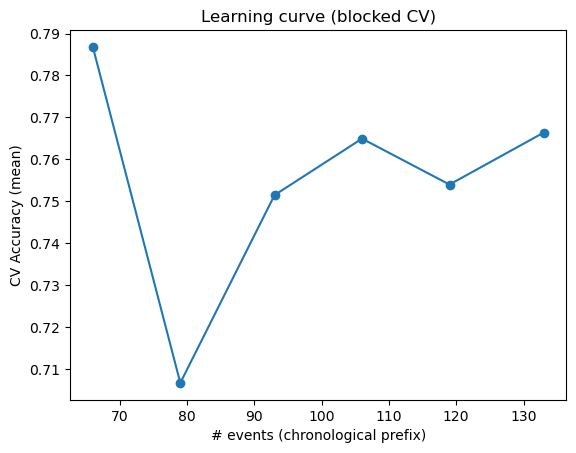

In [20]:
# If already tuned RF with the robust pipeline, those params can be re-used:
tuned = results_pp_rewarded[0].best_params   # from rf_blockcv_grid_with_holdout_robust

# Build learning curves (no re-tuning; use tuned params):
lc_df = learning_curves_blocked(events_rewarded, event_arm_ids_rewarded,
   order_index=None, fractions=(0.5, 0.6, 0.7, 0.8, 0.9, 1.0), n_blocks=5, min_spikes=100,
   target_len="median_pad",     # Same policy as main pipeline
   time_resize="truncate", pca_dims=None, random_state=42,
   re_tune=False,      # to reuse tuned params put True
   rf_params=tuned,    # pass tuned params here
   duration_outlier_method="mad", duration_outlier_thresh=6.0)

# Or, if prefer re-tuning per fraction:
   # lc_df = learning_curves_blocked(
   #     event_matrices, arm_ids,
   #     re_tune=True, param_grid=None,     # use the built-in small grid
   # )

# Plotting 
import matplotlib.pyplot as plt
plt.plot(lc_df["n_events"], lc_df["cv_acc_mean"], marker="o")
plt.xlabel("# events (chronological prefix)")
plt.ylabel("CV Accuracy (mean)")
plt.title("Learning curve (blocked CV)")
plt.show()

In [21]:
# Plotting utilities

# - plot_holdout_confusion_from_result:
#     Rebuilds the TRAIN+VAL vs TEST split from a HoldoutResult (same frac/gap),
#     applies the SAME preprocessing (duration-outlier removal, neuron filtering,
#     target_len policy, time resize, scaling, optional PCA), retrains RF on
#     TRAIN+VAL with result.best_params, predicts on TEST, and plots the
#     confusion matrix. Returns (fig, per_class_df, global_metrics, classes_present).
#
# - plot_top_neuron_importances_from_result:
#     Trains RF on TRAIN+VAL for the given split and plots Top-N neuron
#     importances (sum over time/position bins). Requires NO PCA to preserve
#     neuron↔feature mapping. Returns (fig, neuron_importances_df).
#
# Notes:
#   This cell RELIES on helpers defined in the previous cells:
#       _resize_time, _build_X, _compute_T_from_lens, _filter_length_outliers
#   Accepts either a list of (neurons x time) events or a 3D tensor
#     (neurons, events, position); in the latter case we slice per event.


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support,
    balanced_accuracy_score, f1_score)
from sklearn.ensemble import RandomForestClassifier


def _prepare_events_and_labels_for_plotting(event_matrices, arm_ids, order_index, logger=None):
    """
    Accept a list of events (neurons x time) OR a 3D tensor (neurons, events, position),
    apply optional ordering, and return (events_list, y_raw).
    """
    # Accept tensor (neurons, events, position)
    if isinstance(event_matrices, np.ndarray) and event_matrices.ndim == 3:
        nN, nE, nP = event_matrices.shape
        events = [event_matrices[:, i, :] for i in range(nE)]
    else:
        # Accept Python list or object-dtype np.array of per-event matrices
        events = list(event_matrices if not (isinstance(event_matrices, np.ndarray) and event_matrices.dtype == object)
                      else event_matrices)
    y_raw = np.asarray(arm_ids)

    # Optional chronological order
    if order_index is not None:
        order_index = np.asarray(order_index, int)
        events = [events[i] for i in order_index]
        y_raw = y_raw[order_index]

    return events, y_raw


def _apply_duration_outlier_filter(events, y_raw, duration_outlier_method, duration_outlier_thresh, logger=None):
    """
    Apply the SAME robust duration outlier filter used in training,
    so the split indices line up with what the model saw.
    """
    keep_len = _filter_length_outliers(events, method=duration_outlier_method,
                                       thresh=duration_outlier_thresh, logger=logger)
    if not np.all(keep_len):
        events = [e for e, k in zip(events, keep_len) if k]
        y_raw = y_raw[keep_len]
    return events, y_raw


def plot_holdout_confusion_from_result(event_matrices, arm_ids, result, *, order_index=None, min_spikes=100,
    target_len="median",       # "median" | "median_pad" | "median_truncate" | "median_minus_std" | int
    time_resize="pad",         # base mode; may be overridden by target_len policy
    pca_dims=None,             # optional PCA (fit on TRAIN+VAL, transform TEST)
    duration_outlier_method="mad", duration_outlier_thresh=6.0, random_state=42, title=None):
    """
    Reproduce the TEST evaluation for a given HoldoutResult (split_id/frac/gap),
    plot the confusion matrix, and return detailed metrics.

    Returns
    -------
    fig_conf : matplotlib.figure.Figure
    per_class_df : pd.DataFrame  # precision/recall/F1/support per class (index = original labels)
    global_metrics : dict        # accuracy, balanced_accuracy, macro_f1, weighted_f1
    classes_present : np.ndarray # original class labels in order of first appearance
    """
    # prepare data (support 3D tensor) 
    events, y_raw = _prepare_events_and_labels_for_plotting(event_matrices, arm_ids, order_index)

    # remove duration outliers (same as training) 
    events, y_raw = _apply_duration_outlier_filter(events, y_raw, duration_outlier_method, duration_outlier_thresh)
    N = len(events)

    # map labels to integers (keep original order) 
    seen, classes_present = set(), []
    for v in y_raw:
        if v not in seen:
            seen.add(v); classes_present.append(v)
    classes_present = np.array(classes_present, dtype=object)
    y_all = np.array([np.where(classes_present == v)[0][0] for v in y_raw], dtype=int)
    K = len(classes_present)

    # Consistency: same #neurons across events 
    nset = {M.shape[0] for M in events}
    if len(nset) != 1:
        raise ValueError(f"All events must share the same #neurons. Found: {nset}")
    n_neurons = next(iter(nset))

    # Reconstruct split indices exactly like in training 
    frac = float(result.holdout_frac)
    gap = int(result.gap)
    n_test = max(1, int(round(N * frac)))
    n_trainval = max(2, N - n_test - gap)
    if n_trainval < 2:
        raise ValueError("Not enough TRAIN+VAL samples after filtering to reproduce the split.")
    idx_trval = np.arange(0, n_trainval)
    idx_test  = np.arange(n_trainval + gap, N)

    ev_trval = [events[i] for i in idx_trval]; y_trval = y_all[idx_trval]
    ev_test  = [events[i] for i in idx_test];  y_test_all = y_all[idx_test]

    # TRAIN+VAL-only preprocessing (leakage-free) 
    # 1) Neuron filtering by min_spikes
    total = np.zeros(n_neurons, float)
    for M in ev_trval:
        total += np.nansum(M, axis=1, dtype=np.float64)
    keep_trval = total >= float(min_spikes)
    if keep_trval.sum() == 0:
        raise ValueError("Zero neurons kept after filtering; relax 'min_spikes'.")

    # 2) Choose T from TRAIN+VAL lengths (policy = target_len)
    lens_trval = np.array([M.shape[1] for M in ev_trval])
    T_trval = _compute_T_from_lens(lens_trval, target_len)
    if T_trval < 1:
        raise ValueError("Invalid target_len: T < 1.")

    # 3) Enforce resize policy implied by target_len
    time_resize_eff = time_resize
    if isinstance(target_len, str):
        if target_len == "median_pad":
            time_resize_eff = "pad"
        if target_len in ("median_minus_std", "median_truncate"):
            time_resize_eff = "truncate"

    # 4) Build design matrices with EXACT width T (helpers guarantee same shape)
    X_trval = _build_X(ev_trval, keep_trval, T_trval, time_resize_eff)
    X_test  = _build_X(ev_test,  keep_trval, T_trval, time_resize_eff)

    # 5) Scale (fit on TRAIN+VAL) + optional PCA (fit on TRAIN+VAL)
    scaler = StandardScaler().fit(X_trval)
    X_trval_s = scaler.transform(X_trval)
    X_test_s  = scaler.transform(X_test)

    if pca_dims is not None:
        n_comp = int(min(pca_dims, X_trval_s.shape[0], X_trval_s.shape[1]))
        if n_comp >= 1:
            pca = PCA(n_components=n_comp, random_state=random_state).fit(X_trval_s)
            X_trval_s = pca.transform(X_trval_s)
            X_test_s  = pca.transform(X_test_s)

    # 6) Evaluate only on classes seen in TRAIN+VAL (realistic; avoids impossible targets)
    cls_trval = set(np.unique(y_trval))
    mask_eval = np.array([yt in cls_trval for yt in y_test_all], bool)
    if not mask_eval.any():
        raise ValueError("No evaluable TEST samples (all TEST classes unseen in TRAIN+VAL).")
    X_te_eval, y_te_eval = X_test_s[mask_eval], y_test_all[mask_eval]

    # ---------------- Train final RF and predict on TEST ----------------
    rf = RandomForestClassifier(
        **result.best_params, class_weight="balanced", random_state=random_state, n_jobs=-1
    ).fit(X_trval_s, y_trval)
    y_hat = rf.predict(X_te_eval)

    # ---------------- Confusion matrix + per-class and global metrics ----------------
    labels_idx = np.arange(K)  # include all known classes (rows with zero support will be all-zeros)
    cm = confusion_matrix(y_te_eval, y_hat, labels=labels_idx, normalize="true")

    fig_conf, ax = plt.subplots(figsize=(6.0, 5.2))
    disp = ConfusionMatrixDisplay(cm, display_labels=classes_present)
    disp.plot(ax=ax, values_format=".2f", colorbar=False)
    ax.set_title(title or f"Confusion Matrix — TEST (split {result.split_id}, frac={result.holdout_frac}, gap={result.gap})")
    fig_conf.tight_layout()

    prec, rec, f1, supp = precision_recall_fscore_support(y_te_eval, y_hat, labels=labels_idx, zero_division=0)
    
    per_class_df = pd.DataFrame({"precision": prec, "recall": rec, "f1": f1, "support": supp}, index=classes_present)
    
    global_metrics = {"accuracy": float((y_te_eval == y_hat).mean()),
        "balanced_accuracy": float(balanced_accuracy_score(y_te_eval, y_hat)),
        "macro_f1": float(f1_score(y_te_eval, y_hat, average="macro")),
        "weighted_f1": float(f1_score(y_te_eval, y_hat, average="weighted")),}
    
    return fig_conf, per_class_df, global_metrics, classes_present


def plot_top_neuron_importances_from_result(event_matrices, arm_ids, result, *,
    order_index=None, min_spikes=100,
    target_len="median",       # "median" | "median_pad" | "median_truncate" | "median_minus_std" | int
    time_resize="pad",         # base mode; may be overridden by target_len policy
    duration_outlier_method="mad", duration_outlier_thresh=6.0,
    random_state=42, top_n=20, title=None):
    """
    Train the final RF on TRAIN+VAL (for the given split) and plot Top-N neuron importances.
    IMPORTANT: Do NOT use PCA here (keep pca_dims=None in your main training) to preserve
               the neuron↔feature mapping; otherwise importances cannot be mapped to neurons.

    Returns
    -------
    fig : matplotlib.figure.Figure
    neuron_importances_df : pd.DataFrame  # columns: ['neuron_index', 'importance'], sorted desc
    """
    # Prepare data (support 3D tensor) 
    events, y_raw = _prepare_events_and_labels_for_plotting(event_matrices, arm_ids, order_index)

    # Remove duration outliers (same as training) 
    events, y_raw = _apply_duration_outlier_filter(events, y_raw, duration_outlier_method, duration_outlier_thresh)
    N = len(events)

    # ---------------- Map labels to integers (order-of-appearance) ----------------
    seen, classes_present = set(), []
    for v in y_raw:
        if v not in seen:
            seen.add(v); classes_present.append(v)
    classes_present = np.array(classes_present, dtype=object)
    y_all = np.array([np.where(classes_present == v)[0][0] for v in y_raw], dtype=int)

    # ---------------- Consistency: same #neurons ----------------
    nset = {M.shape[0] for M in events}
    if len(nset) != 1:
        raise ValueError(f"All events must share the same #neurons. Found: {nset}")
    n_neurons = next(iter(nset))

    # ---------------- Reconstruct TRAIN+VAL indices ----------------
    frac = float(result.holdout_frac)
    gap = int(result.gap)
    n_test = max(1, int(round(N * frac)))
    n_trainval = max(2, N - n_test - gap)
    if n_trainval < 2:
        raise ValueError("Not enough TRAIN+VAL samples after filtering to reproduce the split.")
    idx_trval = np.arange(0, n_trainval)

    ev_trval = [events[i] for i in idx_trval]; y_trval = y_all[idx_trval]

    # ---------------- TRAIN+VAL-only preprocessing (NO PCA here) ----------------
    # 1) Neuron filtering
    total = np.zeros(n_neurons, float)
    for M in ev_trval:
        total += np.nansum(M, axis=1, dtype=np.float64)
    keep_trval = total >= float(min_spikes)
    if keep_trval.sum() == 0:
        raise ValueError("Zero neurons kept after filtering; relax 'min_spikes'.")

    # 2) Choose T from TRAIN+VAL lengths (policy)
    lens_trval = np.array([M.shape[1] for M in ev_trval])
    T_trval = _compute_T_from_lens(lens_trval, target_len)
    if T_trval < 1:
        raise ValueError("Invalid target_len: T < 1.")

    # 3) Enforce resize policy implied by target_len
    time_resize_eff = time_resize
    if isinstance(target_len, str):
        if target_len == "median_pad":
            time_resize_eff = "pad"
        if target_len in ("median_minus_std", "median_truncate"):
            time_resize_eff = "truncate"

    # 4) Build TRAIN+VAL design matrix and scale
    X_trval = _build_X(ev_trval, keep_trval, T_trval, time_resize_eff)
    scaler = StandardScaler().fit(X_trval)
    X_trval_s = scaler.transform(X_trval)

    # Train RF (NO PCA) and compute neuron importances 
    rf = RandomForestClassifier(**result.best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_trval_s, y_trval)

    if not hasattr(rf, "feature_importances_"):
        raise RuntimeError("The classifier does not expose feature_importances_.")

    # Map importances back to neurons: reshape to (neurons_kept x T) and sum over T
    fi = rf.feature_importances_
    try:
        fi_by_neuron_kept = fi.reshape(keep_trval.sum(), T_trval).sum(axis=1)
    except Exception as e:
        raise RuntimeError(f"Could not reshape feature importances to (neurons, T): {e}")

    fi_full = np.zeros(n_neurons, float)
    fi_full[np.where(keep_trval)[0]] = fi_by_neuron_kept

    neuron_importances_df = pd.DataFrame({"neuron_index": np.arange(n_neurons, dtype=int),
        "importance": fi_full}).sort_values("importance", ascending=False).reset_index(drop=True)

    # ---------------- Plot Top-N ----------------
    top_n = int(min(int(top_n), max(1, (neuron_importances_df["importance"] > 0).sum())))
    fig, ax = plt.subplots(figsize=(7.0, 4.2))
    top_df = neuron_importances_df.head(top_n).sort_values("importance", ascending=True)
    ax.barh(top_df["neuron_index"].astype(str), top_df["importance"])
    ax.set_xlabel("Average importance (sum over bins)")
    ax.set_ylabel("Neuron")
    ax.set_title(title or f"Top-{top_n} neurons — split {result.split_id} (frac={result.holdout_frac}, gap={result.gap})")
    fig.tight_layout()

    return fig, neuron_importances_df


def pick_best_result(results, metric="accuracy"):
    """
    Select the HoldoutResult with the highest test metric.
    metric ∈ {"accuracy","balanced_accuracy","macro_f1","weighted_f1"}.
    """
    import math
    if not results:
        raise ValueError("Empty results list.")
    def val(res):
        v = res.test_metrics.get(metric, float("nan"))
        return -1.0 if (v is None or (isinstance(v, float) and math.isnan(v))) else float(v)
    best_idx = max(range(len(results)), key=lambda i: val(results[i]))
    return best_idx, results[best_idx]

Using split 0 with macro-F1=1.000


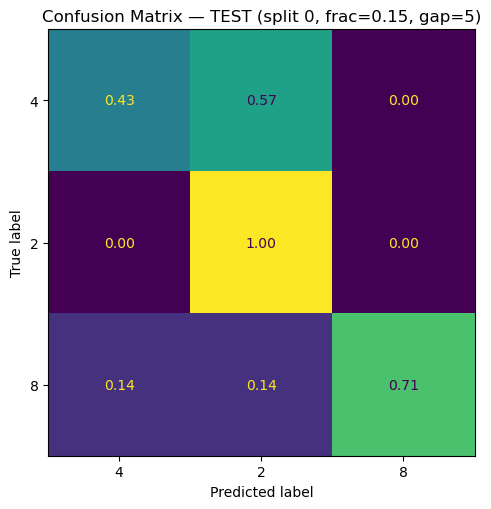

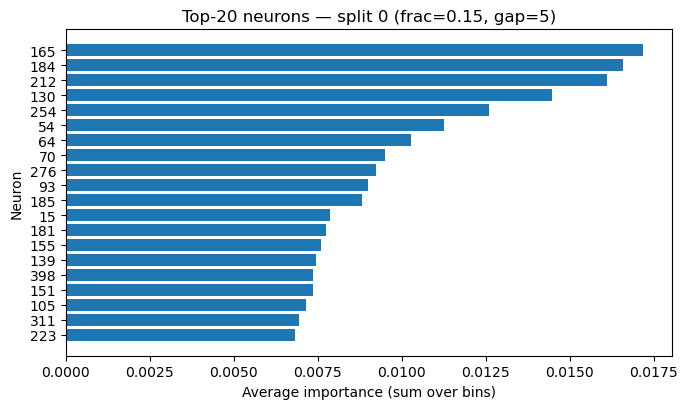

In [22]:
# example (for rewarded events): choose by best macro-F1
best_i_rew, results_b_rew = pick_best_result(results_pp_rewarded, metric="macro_f1")
print(f"Using split {best_i_rew} with macro-F1={results_b_rew .test_metrics['macro_f1']:.3f}")

# 1) Confusion matrix for a specific HoldoutResult `res`:
fig_rewarded, per_class_df_rewarded, global_metrics_rewarded, classes_rewarded = plot_holdout_confusion_from_result(events_rewarded, event_arm_ids_rewarded, results_b_rew,
    order_index=None, min_spikes=100,
    target_len="median_pad",   # SAME policy as in the training
    time_resize="truncate",
    pca_dims=None,                   # or an int if you used PCA for TEST reporting
    duration_outlier_method="mad",
    duration_outlier_thresh=6.0, random_state=42, title=None)

# 2) Top-N neuron importances (requires NO PCA in training):
fig_imp_rewarded, imp_df_rewarded = plot_top_neuron_importances_from_result(events_rewarded, event_arm_ids_rewarded, results_b_rew,
    order_index=None, min_spikes=100, target_len="median_pad",
    time_resize="truncate", duration_outlier_method="mad",
    duration_outlier_thresh=6.0, random_state=42, top_n=20, title=None)

In [23]:
# Save `event_intervals_ms_rewarded` into decoding_data.pkl
import os, pickle
OUT = "decoding_data.pkl"

if "event_intervals_ms_rewarded" not in globals():
    raise NameError("Variable 'event_intervals_ms_rewarded' is not defined in this notebook.")

payload = {"event_intervals_ms_rewarded": event_intervals_ms_rewarded}
with open(OUT, "wb") as f:
    pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

try:
    n = len(event_intervals_ms_rewarded)
except Exception:
    n = "N/A"
print(f"Saved 'event_intervals_ms_rewarded' (len={n}) to {OUT} ✔️")

Saved 'event_intervals_ms_rewarded' (len=133) to decoding_data.pkl ✔️
